In [28]:
import datetime as dt
import gc
import os
import pickle as pkl
import time as timer
from functools import partial
import dateutil.parser as ps
import dateutil.relativedelta as rd
from ipywidgets import HTML, IntProgress, Text
import IPython.display as disp

import cartopy as ctp
import dask
import matplotlib as mpl
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import numpy.random as ran
import scipy.stats as ss
import pandas as pd
import seaborn as sns
import xarray as xr
from joblib import Parallel, delayed
from netCDF4 import Dataset

import kolmogorov_smirnov as ks
import mannwhitneyu as mwu

In [2]:
# Initialize some stuff, tests to explore data structure

pathbase = "../data/"
firstpath = pathbase + "control/0000/"

dirnames = [x[0].split("/")[-1] for x in os.walk(firstpath)]
dirnames.remove("restart")
dirnames.remove("")
unfiltered_variables = {}


def all_mda(var):
    attributes = {}
    for key in var.ncattrs():
        attributes[key] = var.getncattr(key)
    attributes["shape"] = var.shape
    return attributes


for dirname in dirnames:
    afile = next(os.walk(firstpath + dirname + "/"))[2][0]
    aDset = Dataset(firstpath + dirname + "/" + afile, "r")
    thesevars = {}
    for key, var in aDset.variables.items():
        thesevars[key] = all_mda(var)
    unfiltered_variables[dirname] = thesevars

thesekeys = [
    "time",
    "rotated_pole",
    "rlon",
    "rlat",
    "lon",
    "lat",
]

griddata = {key: aDset[key][:].data for key in thesekeys}
nx, ny = griddata["lon"].shape
lon = griddata["lon"][:]
lat = griddata["lat"][:]
rlon = griddata["rlon"][:]
rlat = griddata["rlat"][:]
with open(f"../data/main/griddata.pickle", "wb") as handle:
    pkl.dump(griddata, handle)

In [3]:
n_sel = 100  # how many times we randomly select runs, make it n_sel % n_engine = 0
alpha = 0.05  # significance level
n_mem = 10  # members per ensemble
freq = "1D"
n_sam = {f"{i}D": i * 7 for i in range(1, 8)}
n_sam["1w"] = 50
n_sam["2w"] = 100
n_sam["1M"] = 200
u_crit = 8  # nm = 20
t_crit = 2.024  # nm = 20
replace = False  # to bootstrap or not to bootstrap
nbins = 100  # Kolmogorov-Smirnov
c_alpha = 1.358  # Kolmogorov-Smirnov

# The time period for the tests :
tsta = "19890101"  # Keep day in for ps.parse() to work
nicertsta = ps.isoparse(tsta).strftime("%Y-%m-%d")
n_months = 120
to_load = {}
for dire in dirnames:
    to_load[dire] = [
        "lffdm" + (ps.parse(tsta) + rd.relativedelta(months=x)).strftime("%Y%m") + ".nc"
        for x in range(n_months)
    ]


# All the data
paths = [
    "../data/control/",
    "../data/control2/",
    "../data/ref/",
    "../data/sp/",
    "../data/diff/",
]
n_comp = len(paths)

# Different structures : a forward map from list to nested dictionaries
variablemap = {
    "t_850hPa": ["24h", "T", 2, "Temperature @ 850hPa"],
    "fi_500hPa": ["12h", "FI", 1, "Geopotential @ 500hPa"],
    "u_100m": ["24h_100zlev", "U", 0, "U @ 100m"],
    "v_100m": ["24h_100zlev", "V", 0, "V @ 100m"],
    "u_10m": ["24h_2D", "U_10M", "U @ 10m"],
    "t_2m": ["24h_2D", "T_2M", "Temperature @ 2m"],
    "tot_prec": ["24h_2D", "TOT_PREC", "Precipitation"],
    "athb_t": ["24h_2D", "ATHB_T", "Avg. TOA Out LW Rad."],
    "td_2m": ["24h_2D", "TD_2M", "Dew Point Temperature @ 2m"],
    "tmax_2m": ["24h_2D", "TMAX_2M", "Max. Temperature @ 2m"],
    "tmin_2m": ["24h_2D", "TMIN_2M", "Min. Temperature @ 2m"],
    "t_so_first": ["24h_2D", "T_SO", 0, "Soil Temperature @ -5mm"],
    "t_so_third": ["24h_2D", "T_SO", 2, "Soil Temperature @ -70mm"],
    "t_so_fifth": ["24h_2D", "T_SO", 4, "Soil Temperature @ -340mm"],
    "qv_2m": ["24h_2D", "QV_2M", "Spec. Humidity @ 2m"],
    "t_s": ["24h_2D", "T_S", "Surface Temperature"],
    "tqi": ["24h_2D", "TQI", "Total Cloud Ice"],
    "tqv": ["24h_2D", "TQV", "Total Water Vapor"],
    "clct": ["24h_2D", "CLCT", "Total Cloud Cover"],
    "alhfl_s": ["24h_2D", "ALHFL_S", "Avg. Surf. Latent Heat Flux"],
    "ashfl_s": ["24h_2D", "ASHFL_S", "Avg. Surf. Sensible Heat Flux"],
    "ps": ["12h_2D", "PS", "Surface Pressure"],
}

# Useful dicts for efficient data loading
careabout = {}
dontcareabout = {}

# Each big dataset that we load : which are the wanted variables (drop the others)
for key in dirnames:
    careabout[key] = {}
    dontcareabout[key] = []
for key, value in variablemap.items():
    careabout[value[0]][key] = value[1]

    # How to drop the other variables :
for dire, varlist in unfiltered_variables.items():
    for varname in varlist.keys():
        if varname not in careabout[dire].values() and varname not in thesekeys:
            dontcareabout[dire].append(varname)

comps = np.array([path.split("/")[-2] for path in paths])
n_comp = len(comps)
notref = np.where(comps != "ref")[0]
ref = np.where(comps == "ref")[0][0]

metadata = {  # Need a dict move around more easily
    "n_sel": n_sel,
    "alpha": alpha,
    "n_mem": n_mem,
    "n_sam": n_sam[freq],
    "u_crit": u_crit,
    "t_crit": t_crit,
    "replace": replace,
    "nbins": nbins,
    "c_alpha": c_alpha,
    "tsta": tsta,
    "nx": nx,
    "ny": ny,
    "n_months": n_months,
    "n_comp": n_comp,
    "comps": comps,
    "shape": [n_comp, n_months, nx, ny, n_sam],
    "variablemap": variablemap,
    "months_per_chunk": 6,
    "freq": freq,
}

# with open(f"../data/main/metadata.pickle", "wb") as handle:
#     pkl.dump(metadata, handle)

for pathbase in ["results", "rejection"]:
    if not os.path.isdir(f"../data/{pathbase}/{freq}"):
        os.mkdir(f"../data/{pathbase}/{freq}")
    with open(f"../data/{pathbase}/{freq}/metadata.pickle", "wb") as handle:
        pkl.dump(metadata, handle)

HERE = "__xarray_dataarray_variable__"

In [44]:
wall_clock_time = {"12": "03:00:00", "24": "03:00:00"}
at_once = {"12": 1, "24": 1}


with open(f"../data/results/{freq}/metadata.pickle", "rb") as handle:
    metadata = pkl.load(handle)

for varname, value in metadata["variablemap"].items():
    h = value[0][:2]
    f = open(f"scripts/job_{varname}.sbatch", "w")

    f.write("#!/bin/bash -l \n")
    f.write(f"#SBATCH --job-name='study_{varname}_{freq}'\n")
    f.write(f"#SBATCH --output=.out/{varname}_{freq}.out\n")
    f.write(f"#SBATCH --error=.out/{varname}_{freq}.err\n")
    f.write("#SBATCH --account='pr133'\n")
    f.write(f"#SBATCH --time={wall_clock_time[h]}\n")
    f.write("#SBATCH --nodes=1\n")
    f.write("#SBATCH --ntasks-per-core=2\n")
    f.write("#SBATCH --ntasks-per-node=1\n")
    f.write("#SBATCH --cpus-per-task=24\n")
    f.write("#SBATCH --partition=normal\n")
    f.write("#SBATCH --constraint=gpu\n")
    f.write("#SBATCH --hint=multithread\n")
    f.write("\n")
    f.write("export OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK\n")
    f.write("\n")
    f.write("conda activate env\n")
    f.write(f"srun -o python one_ks.py {varname} {at_once[h]} {freq} \n")

    f.close()

In [198]:
def write_to_disk(thisdarray, smallname, file_letter, k, vm):
    if len(vm) == 4:
        thisdarray = thisdarray[..., vm[2]]
    thisdarray.to_netcdf(f"../data/main/{smallname}{file_letter}{k}.nc")

In [199]:
def open_and_load(
    allpaths,
    careabout,
    dontcareabout,
    file_letter,
    k,
    variablemap,
    parallel_write=False,
):
    Dset = xr.open_mfdataset(
        allpaths,
        combine="nested",
        concat_dim=["member", "comp", "time"],
        parallel=True,
        drop_variables=dontcareabout,
        join="override",
    ).transpose("comp", "time", "rlat", "rlon", "member", ...)
    if "srlat" in Dset.dims:
        Dset = Dset.transpose(
            "comp", "time", "rlat", "srlat", "rlon", "srlon", "member", ...
        )
    if parallel_write:
        Parallel(
            n_jobs=min(24, len(careabout)),
            verbose=12,
            max_nbytes=None,
            pre_dispatch="all",
        )(
            delayed(write_to_disk)(
                Dset[bigname], smallname, file_letter, k, variablemap[smallname]
            )
            for smallname, bigname in careabout.items()
        )
    else:
        for smallname, bigname in careabout.items():
            write_to_disk(
                Dset[bigname], smallname, file_letter, k, variablemap[smallname]
            )
    Dset.close()
    del Dset
    gc.collect()

In [ ]:
months_per_chunk = metadata["months_per_chunk"]  # make it 12 % months_per_loop = 0
n_chunks = int(n_months / months_per_chunk)
file_letter = "s"  # 's' for

dynamic_text = HTML(value=" ", description="In folder :")

disp.display(dynamic_text)

for dire in dirnames[:]:
    h = dire[:2]
    allpaths = [
        [
            [
                [
                    paths[n] + str(i).zfill(4) + "/" + dire + "/" + x
                    for x in to_load[dire][
                        (k * months_per_chunk) : ((k + 1) * months_per_chunk)
                    ]
                ]
                for n in range(n_comp)
            ]
            for i in range(n_mem)
        ]
        for k in range(n_chunks)
    ]
    dynamic_text.value = f"{dire}"
    if len(careabout[dire]) < 3:
        Parallel(n_jobs=n_chunks, verbose=12, max_nbytes=None, pre_dispatch="all")(
            delayed(open_and_load)(
                allpaths[k],
                careabout[dire],
                dontcareabout[dire],
                file_letter,
                k,
                variablemap,
                False,
            )
            for k in range(n_chunks)
        )
    else:
        for k in range(n_chunks):
            open_and_load(
                allpaths[k],
                careabout[dire],
                dontcareabout[dire],
                file_letter,
                k,
                variablemap,
                True,
            )

In [71]:
varname = "ashfl_s"
i = 0
at_once = 4
bigname = variablemap[varname][1]
fnames = [f"../data/main/{varname}s{j}.nc" for j in range(i, i + at_once)]
darr = xr.open_mfdataset(fnames)[bigname]

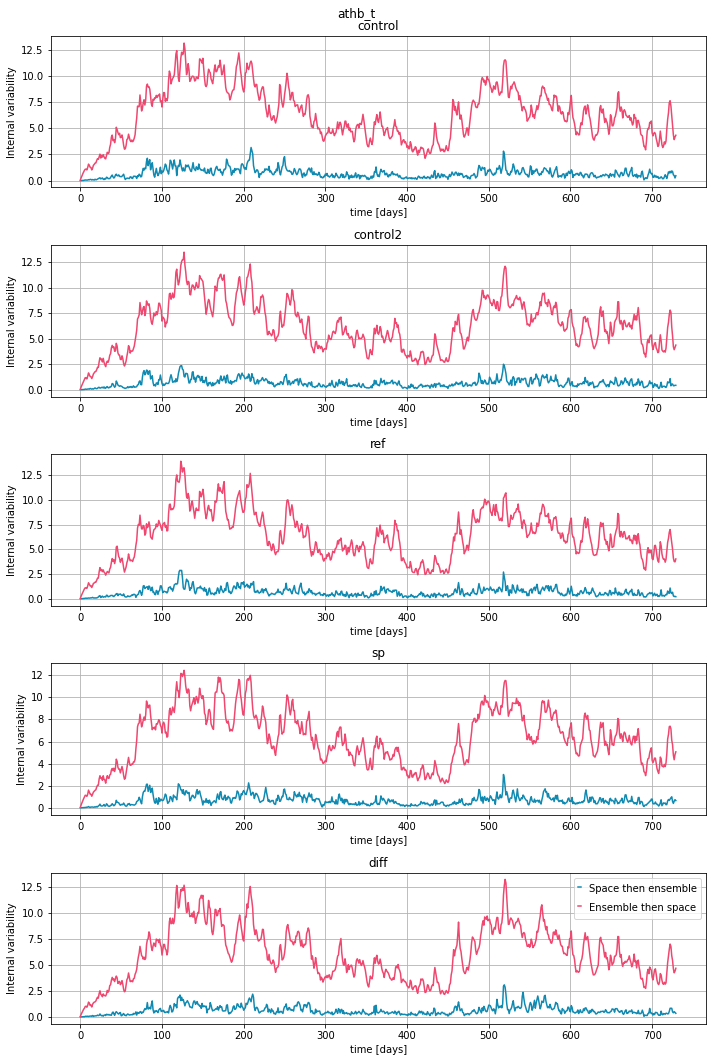

In [39]:
fig, axes = plt.subplots(darr.shape[0], 1, tight_layout=True, figsize=(10, 15))
x = np.arange(darr.shape[1])
colors = ["#073B4C", "#118ab2", "#06D6A0", "#ffd166", "#ef476f"]
fig.suptitle(varname)
for i in range(darr.shape[0]):
    ax = axes[i]
    ax.plot(x, np.std(np.mean(darr[i, :, :, :, :], axis=(1, 2)), axis=-1), color=colors[1], label="Space then ensemble")
    ax.plot(x, np.mean(np.std(darr[i, :, :, :, :], axis=-1), axis=(1, 2)), color=colors[-1], label="Ensemble then space")
    ax.grid(True)
    ax.set_xlabel("time [days]")
    ax.set_ylabel("Internal variability")
    ax.set_title(comps[i])
    
axes[-1].legend()

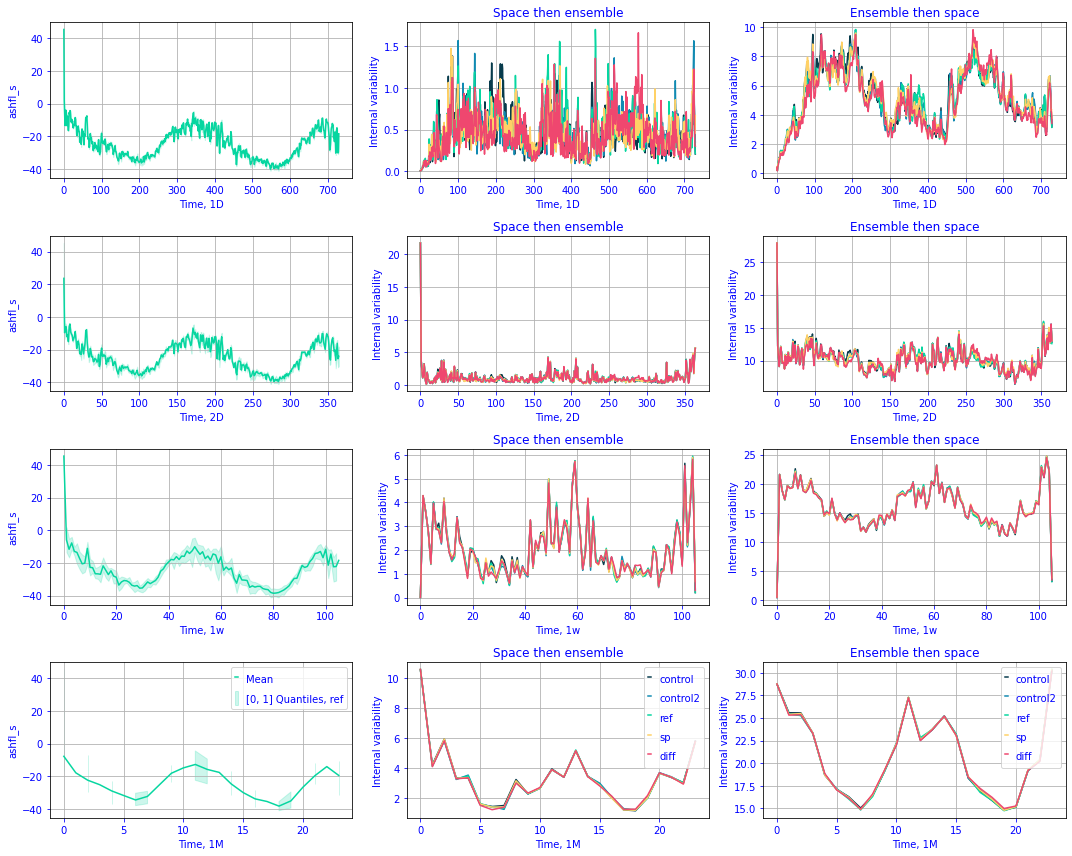

In [72]:
freqs = ["1D", "2D", "1w", "1M"]
fig, axes = plt.subplots(len(freqs), 3, tight_layout=True, figsize=(15, 12))
dims = list(darr.dims)
for i in range(len(freqs)):
    freq = freqs[i]
    groups = darr.resample(time=freq).groups
    subdarrs = [
        darr.isel(time=value).stack(memb=("time", "member")).reset_index("memb")
        for value in groups.values()
    ]
    maxntime = np.amax([subdarr.shape[-1] for subdarr in subdarrs])
    newdims = dims.copy()
    newdims[1] = "newtime"
    newdims[-1] = "memb"
    newdarr = xr.concat(
        [subdarr.pad(memb=(0, maxntime - subdarr.shape[-1])) for subdarr in subdarrs],
        dim="newtime",
    ).transpose(*newdims)
    newdarr.attrs["freq"] = freq
    newdarr = newdarr.reindex(
        {
            "newtime": pd.date_range(
                start=newdarr["time"][0][0].values,
                periods=newdarr.shape[1],
                freq=freq,
            )
        }
    )
    x = np.arange(len(newdarr["newtime"]))
    axes[i, 0].plot(x, np.mean(newdarr[2, :, :, :, :], axis=(1, 2, 3)), color=colors[2], label="Mean")
    axes[i, 0].fill_between(x, 
                            *np.quantile(np.mean(newdarr[2, :, :, :, :], axis=(1, 2)), [0, 1], axis=-1),
                            color=colors[2], 
                            alpha=0.2,
                            label=f"[0, 1] Quantiles, {comps[2]}",
                           )
    axes[i, 0].set_ylabel(varname)
    for j in range(newdarr.shape[0]):
        axes[i, 1].plot(x, np.std(np.mean(newdarr[j, :, :, :, :], axis=(1, 2)), axis=-1), color=colors[j], label=comps[j])
        axes[i, 1].set_title("Space then ensemble")
        axes[i, 1].set_ylabel("Internal variability")
        axes[i, 2].plot(x, np.mean(np.std(newdarr[j, :, :, :, :], axis=-1), axis=(1, 2)), color=colors[j], label=comps[j])
        axes[i, 2].set_title("Ensemble then space")
        axes[i, 2].set_ylabel("Internal variability")
    for ax in axes[i, :]:
        ax.set_xlabel(f"Time, {freqs[i]}")
        ax.grid(True)
axes[-1, 0].legend()
axes[-1, 1].legend()
axes[-1, 2].legend()

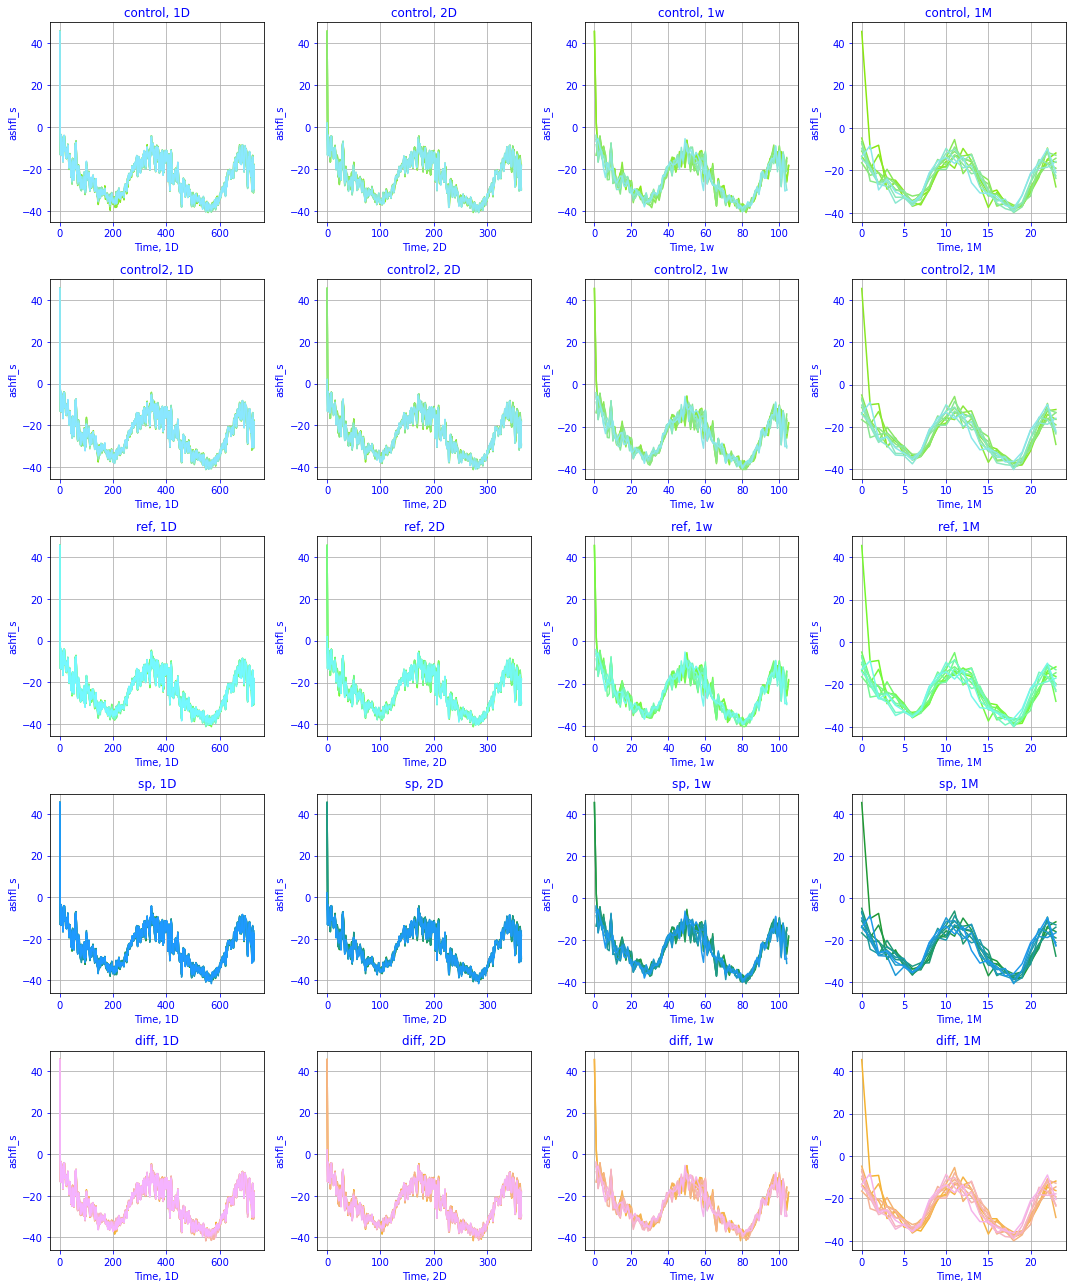

In [73]:
slices = {
    "1D": slice(0, 10, 1), 
    "2D": slice(0, 20, 2), 
    "1w": slice(0, 70, 7),
    "1M": slice(0, 310, 31)
}
freqs = list(slices.keys())
fig, axes = plt.subplots(darr.shape[0], len(freqs), tight_layout=True, figsize=(15, 18))
colors = ["#073B4C", "#118ab2", "#06D6A0", "#ffd166", "#ef476f"]
c = np.empty(len(colors), dtype=object)
for j in range(len(c)):
    c[j] = mpl.colors.rgb_to_hsv(mpl.colors.to_rgb(colors[j]))
dims = list(darr.dims)
for i in range(len(freqs)):
    freq = freqs[i]
    groups = darr.resample(time=freq).groups
    subdarrs = [
        darr.isel(time=value).stack(memb=("time", "member")).reset_index("memb")
        for value in groups.values()
    ]
    maxntime = np.amax([subdarr.shape[-1] for subdarr in subdarrs])
    newdims = dims.copy()
    newdims[1] = "newtime"
    newdims[-1] = "memb"
    newdarr = xr.concat(
        [subdarr.pad(memb=(0, maxntime - subdarr.shape[-1])) for subdarr in subdarrs],
        dim="newtime",
    ).transpose(*newdims)
    newdarr.attrs["freq"] = freq
    newdarr = newdarr.reindex(
        {
            "newtime": pd.date_range(
                start=newdarr["time"][0][0].values,
                periods=newdarr.shape[1],
                freq=freq,
            )
        }
    )
    x = np.arange(len(newdarr["newtime"]))
    for j in range(darr.shape[0]):
        clist = [[c[j][0], c[j][1], l] for l in np.linspace(0.2 * c[j][2], min(5 * c[j][2], 1), newdarr.shape[-1])]
        for k in np.arange(newdarr.shape[-1])[slices[freq]]:
            ax = axes[j, i]
            ax.plot(x, np.mean(newdarr[j, :, :, :, k], axis=(1, 2)), color=clist[k])
            ax.set_xlabel(f"Time, {freq}")
            ax.set_ylabel(varname)
            ax.set_title(f"{comps[j]}, {freq}")
            ax.grid(True)

/tmp/ipykernel_28301/2407861498.py:35: RuntimeWarning: invalid value encountered in true_divide
  to_plot = np.nanmean(autocorr / np.tensordot(np.ones(howmany), autocorr[0], axes=0), axis=(1, 2))
/tmp/ipykernel_28301/2407861498.py:35: RuntimeWarning: invalid value encountered in true_divide
  to_plot = np.nanmean(autocorr / np.tensordot(np.ones(howmany), autocorr[0], axes=0), axis=(1, 2))


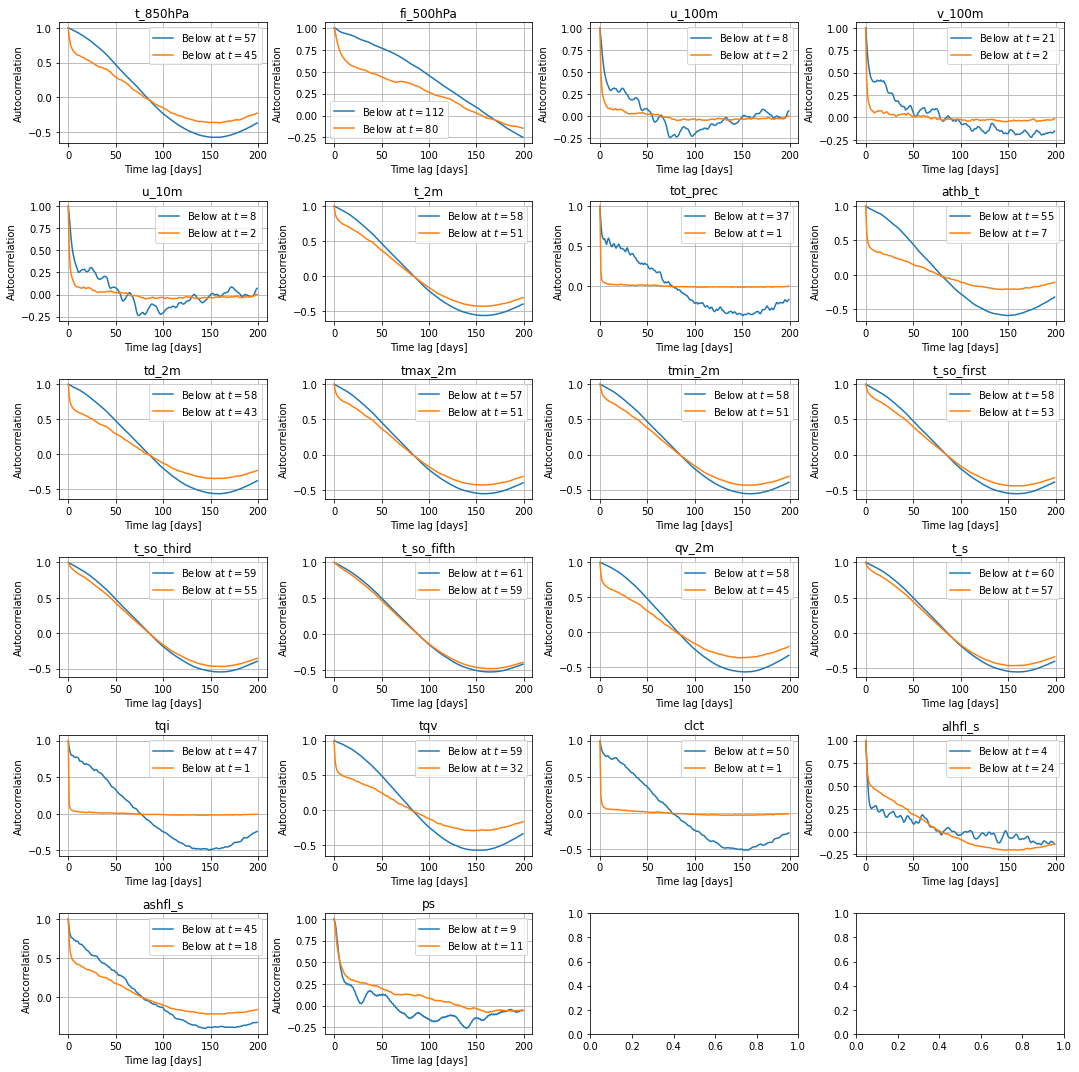

In [143]:
fig, axes = plt.subplots(6, 4, tight_layout=True, figsize=(15, 15))
axes = axes.flatten()
i = 0
wo = {}
for varname in variablemap.keys():
    wo[varname] = []
    ax = axes[i]
    bigname = variablemap[varname][1]
    fnames = [f"../data/main/{varname}s{j}.nc" for j in range(2)]
    darr = xr.open_mfdataset(fnames)[bigname]
    series = np.mean(darr[2, :, :, :, 0], axis=(1, 2)).values
    mean = np.mean(series)
    s = 1
    N = len(series)
    howmany = 200 # N - s
    autocorr = np.empty((howmany))
    for k in range(len(autocorr)):
        autocorr[k] = np.sum((series[k:] - mean) * (series[:N-k] - mean))
    autocorr = autocorr / autocorr[0]
    ax.set_title(varname)
    ax.set_xlabel("Time lag [days]")
    ax.set_ylabel("Autocorrelation")
    ax.grid(True)
    wo[varname].append(np.where(autocorr < 1 / np.e)[0][0])
    # ax.vlines(wo, 0, 1, "k")
    ax.plot(np.arange(len(autocorr)), autocorr, label=f"Below at $t={wo[varname][0]}$")
    
    series = darr[2, :, :, :, 0].values
    N = series.shape[0]
    s = 1
    mean = np.tensordot(np.ones(N), np.mean(series, axis=0), axes=0)
    autocorr = np.empty((howmany, darr.shape[2], darr.shape[3]))
    for k in range(autocorr.shape[0]):
        autocorr[k] = np.sum((series[k:] - mean[k:]) * (series[:N-k] - mean[:N-k]), axis=0)
    to_plot = np.nanmean(autocorr / np.tensordot(np.ones(howmany), autocorr[0], axes=0), axis=(1, 2))
    
    wo[varname].append(np.where(to_plot < 1 / np.e)[0][0])
    ax.plot(np.arange(howmany), to_plot, label=f"Below at $t={wo[varname][1]}$")
    ax.legend()
    i += 1

In [144]:
with open("wo.pickle", "wb") as handle:
    pkl.dump(wo, handle)

In [ ]:
dask.config.set({"array.slicing.split_large_chunks": True})
fig, axes = plt.subplots(10, 5, tight_layout=True, figsize=(18, 40))
axes = axes.flatten()
for s in range(len(axes)):
    where = [np.random.randint(j) for j in newdarr.shape[1:4]]
    # where = [26, 128, 95]
    # idxs_ref = ran.choice(newdarr.shape[-1], n_sam[freq], replace=replace)
    b = newdarr[ref, where[0], where[1], where[2], :].values
    nx = newdarr.shape[-1]
    # idxs = ran.choice(newdarr.shape[-1], n_sam[freq], replace=replace)
    a = newdarr[notref[1], where[0], where[1], where[2], :].values
    x = np.concatenate([a, b], axis=-1)
 
    idxs_ks = np.argsort(x, axis=-1)
    x = np.take_along_axis(x, idxs_ks, axis=-1)
    valx = np.sum(~np.isnan(a))
    y1 = np.cumsum(idxs_ks < nx, axis=-1) / valx
    y2 = np.cumsum(idxs_ks >= nx, axis=-1) / valx
    d = np.amax(np.abs(y1[:2 * valx] - y2[:2 * valx]), axis=-1)
    rej = d > c_alpha * np.sqrt(2 / np.sum(~np.isnan(a)))
    if rej:
        axes[s].set_facecolor("gray")
    axes[s].plot(x, y1)
    axes[s].plot(x, y2)
    axes[s].set_title(f"$t={where[0]}$, $i={where[1]}$, $j={where[2]}$, $d={d:.3f}$, $C={(c_alpha * np.sqrt(2 / np.sum(~np.isnan(a)))):.2f}$")
    axes[s].set_xlabel(varname)
    axes[s].set_ylabel("Empirical CDF")
    axes[s].grid(True)

In [80]:
freq = "1D"
varname = "ashfl_s"
results = xr.open_dataset(f"../data/results/{freq}/{varname}.nc")[HERE].values
avgrej = xr.open_dataset(f"../data/rejection/{freq}/{varname}_avg.nc")[HERE].values
bigname = variablemap[varname][1]
fnames = [f"../data/main/{varname}s{j}.nc" for j in range(2)]
darr = xr.open_mfdataset(fnames)[bigname]
dims = list(darr.dims)
coords={
    dims[i]: darr[dims[i]] for i in range(1, 4)
}
groups = darr.resample(time="1w").groups
subdarrs = [
    darr.isel(time=value).stack(memb=("time", "member")).reset_index("memb")
    for value in groups.values()
]
maxntime = np.amax([subdarr.shape[-1] for subdarr in subdarrs])
newdims = dims.copy()
newdims[1] = "newtime"
newdims[-1] = "memb"
newdarr = xr.concat(
    [subdarr.pad(memb=(0, maxntime - subdarr.shape[-1])) for subdarr in subdarrs],
    dim="newtime",
).transpose(*newdims)
newdarr.attrs["freq"] = "1w"
newdarr = newdarr.reindex(
    {
        "newtime": pd.date_range(
            start=newdarr["time"][0][0].values,
            periods=newdarr.shape[1],
            freq="1w",
        )
    }
)
darr = darr.values
newdarr = newdarr.values

In [137]:
## KS statistic
d = np.empty((len(notref), *darr.shape[1:4]))
exact0 = np.empty((len(notref), *darr.shape[1:4]), dtype=bool)
for n in range(len(notref)):
    b = darr[ref, ...]
    a = darr[notref[n], ...]
    x = np.concatenate([a, b], axis=-1)
    nx = np.sum(~np.isnan(a), axis=-1)
 
    idxs_ks = np.argsort(x, axis=-1)
    x = np.take_along_axis(x, idxs_ks, axis=-1)
    exact0[n, ...] = np.isclose(x[..., 0], x[..., -1], rtol=6e-4)
    y1 = np.cumsum(idxs_ks < nx[:, :, :, np.newaxis], axis=-1) / nx[:, :, :, np.newaxis]
    y2 = np.cumsum(idxs_ks >= nx[:, :, :, np.newaxis], axis=-1) / nx[:, :, :, np.newaxis]
    d[n, ...] = np.amax(np.abs(y1 - y2), axis=-1)

In [136]:
## MWU statistic
U = np.empty((len(notref), *darr.shape[1:4]))
for n in range(len(notref)):
    b = darr[ref, ...]
    a = darr[notref[n], ...]
    b = np.tensordot(b, np.ones(a.shape[-1]), axes=0)
    a = np.tensordot(a, np.ones(b.shape[-1]), axes=0).transpose((0, 1, 2, 4, 3))

    Ua = np.sum(b > a, axis=(3, 4)) + 0.5 * np.sum(b == a, axis=(3, 4))
    Ub = b.shape[-1] * a.shape[-1] - Ua
    U[n, ...] = np.amin(np.array([Ua, Ub]), axis=0)
    del Ua, Ub
    gc.collect()

In [ ]:
## Coccini statistic

b = darr[ref, ...]
a = darr[notref[2], ...]
x = np.concatenate([a, b], axis=-1)
rank = ss.rankdata(x[:, 0, 0, :], axis=-1)
N = rank.shape[-1]
n1 = a.shape[-1]
Uco = (np.sum(rank[..., :n1] ** 2, axis=-1) - n1 * (N + 1) * (2 * N + 1) / 6) / np.sqrt(n1 ** 2 * (N + 1) * (2 * N + 1) * (8 * N + 11) / 180)
Vco = (np.sum((N + 1 - rank[..., :n1]) ** 2, axis=-1) - n1 * (N + 1) * (2 * N + 1) / 6) / np.sqrt(n1 ** 2 * (N + 1) * (2 * N + 1) * (8 * N + 11) / 180)
rho = 2 * (N ** 2 - 4) / (2 * N + 1) / (8 * N + 11) - 1
T_C = Uco ** 2 + Vco ** 2 - 2 * rho * Uco * Vco / 2 / (1 - rho ** 2)

In [151]:
d[exact0] = 0
U[exact0] = 50

In [132]:
reja = d > c_alpha * np.sqrt(2 / 10)
rejb = d > 1.224 * np.sqrt(2 / 10)
rejU01 = U < 16
rejU05 = U < 23
rejU10 = U < 27
reja[exact0] = False
rejb[exact0] = False
rejU01[exact0] = False
rejU05[exact0] = False
rejU10[exact0] = False
avgreja = xr.DataArray(reja, coords=coords).resample(time="1M").mean()
avgrejb = xr.DataArray(rejb, coords=coords).resample(time="1M").mean()
avgrejU01 = xr.DataArray(rejU01, coords=coords).resample(time="1M").mean()
avgrejU05 = xr.DataArray(rejU05, coords=coords).resample(time="1M").mean()
avgrejU10 = xr.DataArray(rejU10, coords=coords).resample(time="1M").mean()

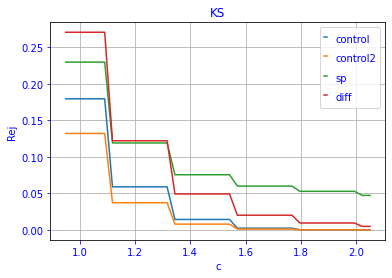

In [174]:
cs = np.linspace(0.95, 2.05, 40)
fig, ax = plt.subplots()
for j in range(len(notref)):
    ax.plot(cs, [np.mean(d[j] > c * np.sqrt(2 / 10)) for c in cs], label=comps[notref[j]])
    # print(f"c = {c:.2f}, {comps[notref[j]]}, : {np.mean(d[j] > c * np.sqrt(2 / 10))}")
ax.set_xlabel("c")
ax.set_ylabel("Rej")
ax.set_title("KS")
ax.grid(True)
ax.legend()

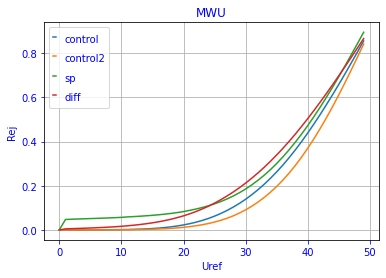

In [175]:
Urefs = np.arange(50)
fig, ax = plt.subplots()
for j in range(len(notref)):
    ax.plot(Urefs, [np.mean(U[j] < Uref) for Uref in Urefs], label=comps[notref[j]])
# print(f"Uref = {Uref}, {comps[notref[j]]}, : {np.mean(U[j] < Uref)}")
ax.set_xlabel("Uref")
ax.set_ylabel("Rej")
ax.set_title("MWU")
ax.grid(True)
ax.legend()

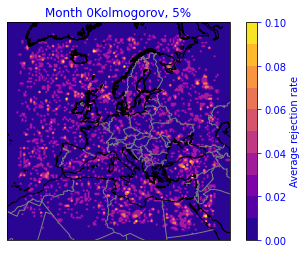

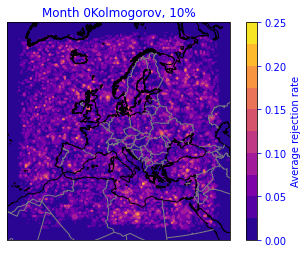

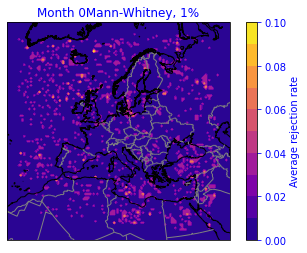

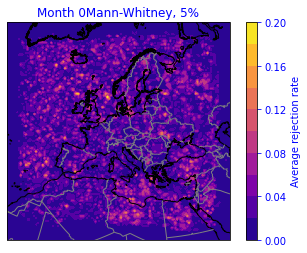

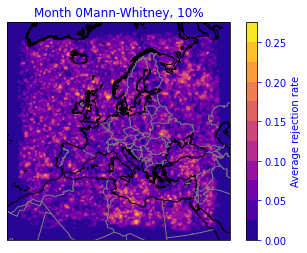

In [22]:
to_plot = [
    avgreja,
    avgrejb,
    avgrejU01,
    avgrejU05,
    avgrejU10
]

titles = [
    "Kolmogorov, 5%",
    "Kolmogorov, 10%",
    "Mann-Whitney, 1%",
    "Mann-Whitney, 5%",
    "Mann-Whitney, 10%",
]
levels = [10, 10, 10, 10, 10]
COLOR = "blue"
mpl.rcParams["text.color"] = COLOR
mpl.rcParams["axes.labelcolor"] = COLOR
mpl.rcParams["xtick.color"] = COLOR
mpl.rcParams["ytick.color"] = COLOR
mpl.rcParams["animation.html"] = "jshtml"
# Projection for map

pole_lat = aDset["rotated_pole"].getncattr("grid_north_pole_latitude")
pole_lon = aDset["rotated_pole"].getncattr("grid_north_pole_longitude")

# Transform for rotated lat/lon
crs_rot = ctp.crs.RotatedPole(pole_longitude=pole_lon, pole_latitude=pole_lat)

# Figure
transform = ctp.crs.PlateCarree()
projection = crs_rot
figs, axes = zip(*[
    plt.subplots(
        1,
        1,
        subplot_kw={"projection": projection}
    )
    for _ in range(len(to_plot))
])
# axes = np.atleast_1d(axes)
cmap = plt.get_cmap("plasma")

# Add coastline and boarders
coastline = ctp.feature.NaturalEarthFeature(
    "physical", "coastline", "10m", edgecolor="black", facecolor="none"
)
borders = ctp.feature.NaturalEarthFeature(
    "cultural", "admin_0_boundary_lines_land", "10m", edgecolor="grey", facecolor="none"
)
plt_rej = []
cbar = [None] * len(to_plot)
for j in range(len(to_plot)):
    ax = axes[j]
    fig = figs[j]
    plt_rej.append(
        ax.contourf(
            lon,
            lat,
            to_plot[j][0],
            levels=levels[j],
            transform=transform,
            transform_first=True,
            cmap=cmap,
            zorder=0,
        )
    )

    ax.add_feature(coastline)
    ax.add_feature(borders)
    ax.set_xmargin(0)
    ax.set_ymargin(0)
    ax.set_title("Month 0, " + titles[j])

    cbar[j] = fig.colorbar(plt_rej[j], ax=ax)
    cbar[j].ax.set_ylabel("Average rejection rate")

def animate(i, j):
    ax = axes[j]
    fig = figs[j]
    global plt_rej
    for c in plt_rej[j].collections:
        c.remove()
    plt_rej[j] = ax.contourf(
        lon,
        lat,
        # lon,
        to_plot[j][i],
        levels=levels[j],
        transform=transform,
        transform_first=True,
        cmap=cmap,
        zorder=0,
    )
    ax.set_title(f"Month {i + 1}, " + titles[j])
    cbar[j] = fig.colorbar(plt_rej[j], cax=fig.axes[1])
    cbar[j].ax.set_ylabel("Average rejection rate")
    return plt_rej

In [23]:
j = 4
anim = animation.FuncAnimation(
    figs[j], partial(animate, j=j), frames=10, repeat=False
)
disp.HTML(anim.to_jshtml())

/project/pr133/hbanderi/miniconda3/envs/env/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'transform_first'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


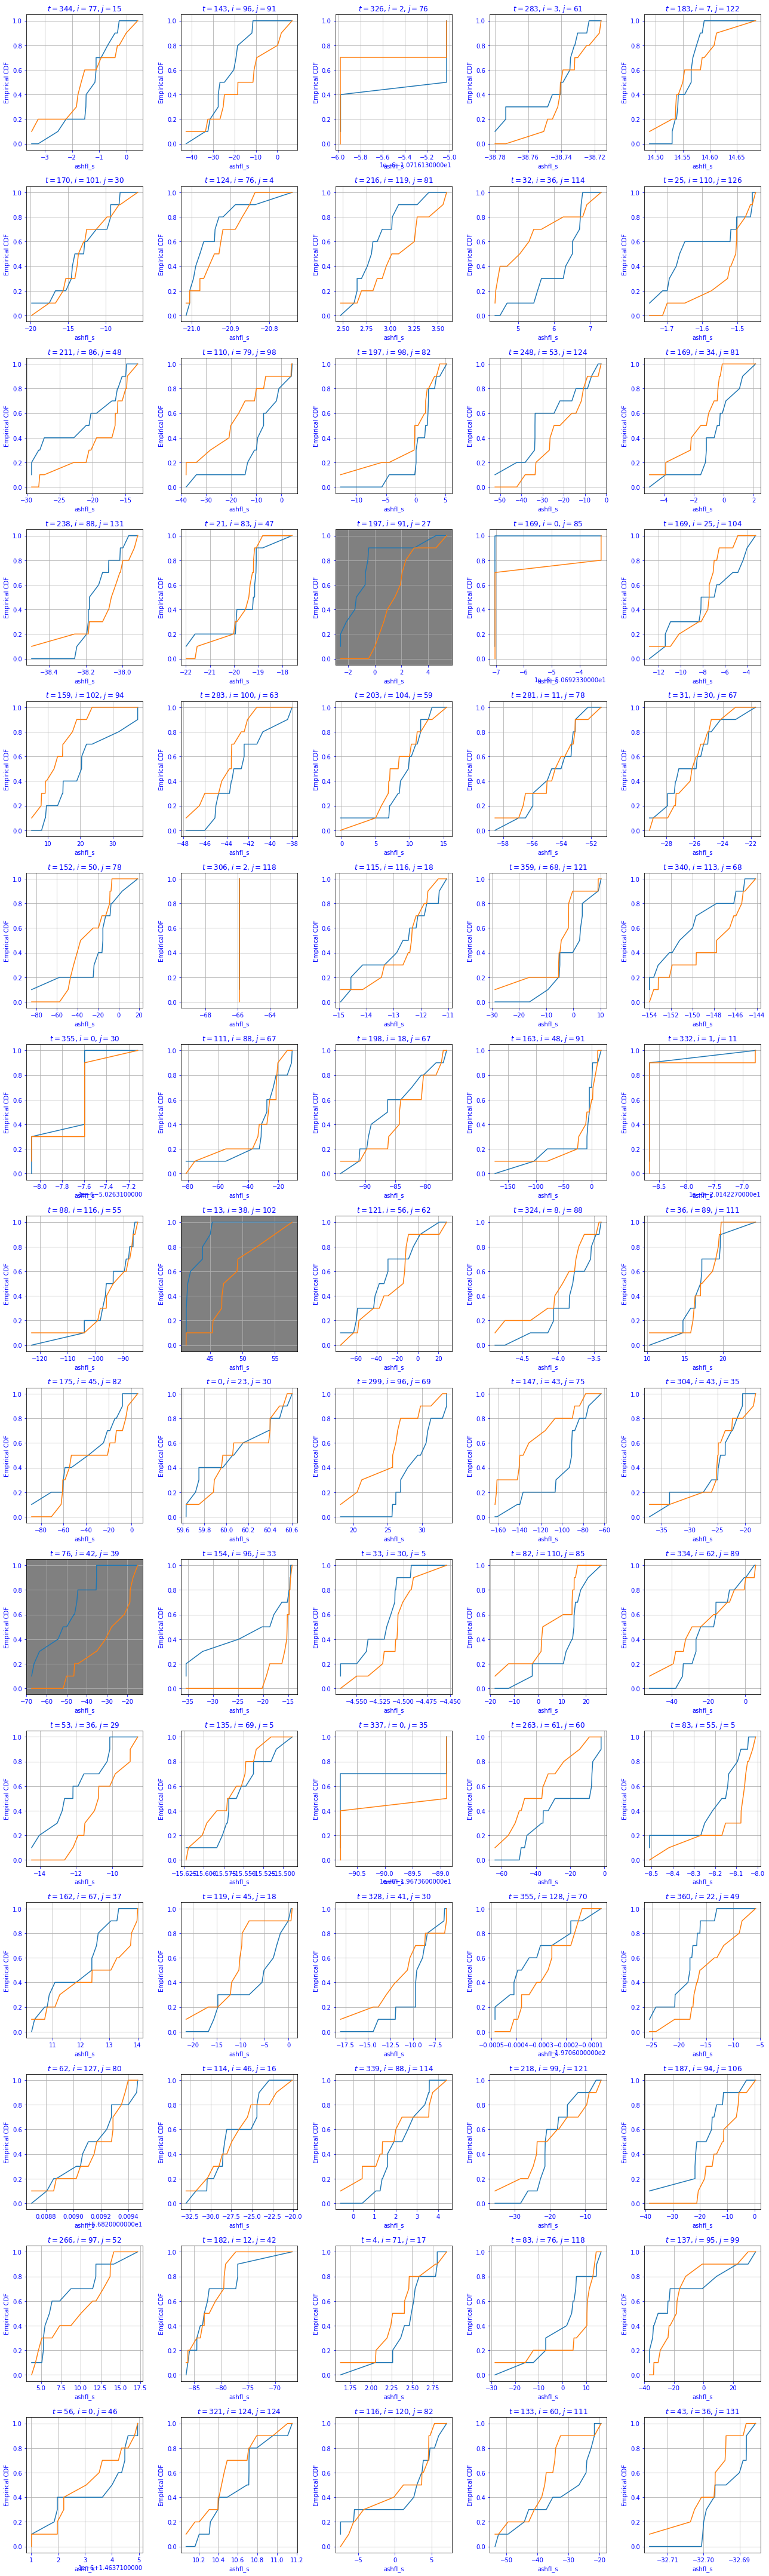

In [68]:
fig, axes = plt.subplots(15, 5, tight_layout=True, figsize=(18, 60))
axes = axes.flatten()
for s in range(len(axes)):
    where = [np.random.randint(j) for j in darr.shape[1:4]]
    # idxs_ref = ran.choice(darr.shape[-1], n_sam["1D"], replace=replace)
    b = darr[ref, where[0], where[1], where[2], :]
    # idxs = ran.choice(darr.shape[-1], n_sam["1D"], replace=replace)
    a = darr[notref[3], where[0], where[1], where[2], :]
    x = np.concatenate([a, b], axis=-1)
    nx = np.sum(~np.isnan(a))
 
    idxs_ks = np.argsort(x, axis=-1)
    x = np.take_along_axis(x, idxs_ks, axis=-1)
    exact = np.isclose(x[..., 0], x[..., -1], rtol=3e-4)
    y1 = np.cumsum(idxs_ks < nx, axis=-1) / nx
    y2 = np.cumsum(idxs_ks >= nx, axis=-1) / nx
    d = np.amax(np.abs(y1 - y2), axis=-1)
    rej = d > c_alpha * np.sqrt(2 / nx)
    if rej and not exact:
        axes[s].set_facecolor("gray")
    axes[s].plot(x, y1)
    axes[s].plot(x, y2)
    axes[s].set_title(f"$t={where[0]}$, $i={where[1]}$, $j={where[2]}$")
    axes[s].set_xlabel(varname)
    axes[s].set_ylabel("Empirical CDF")
    axes[s].grid(True)

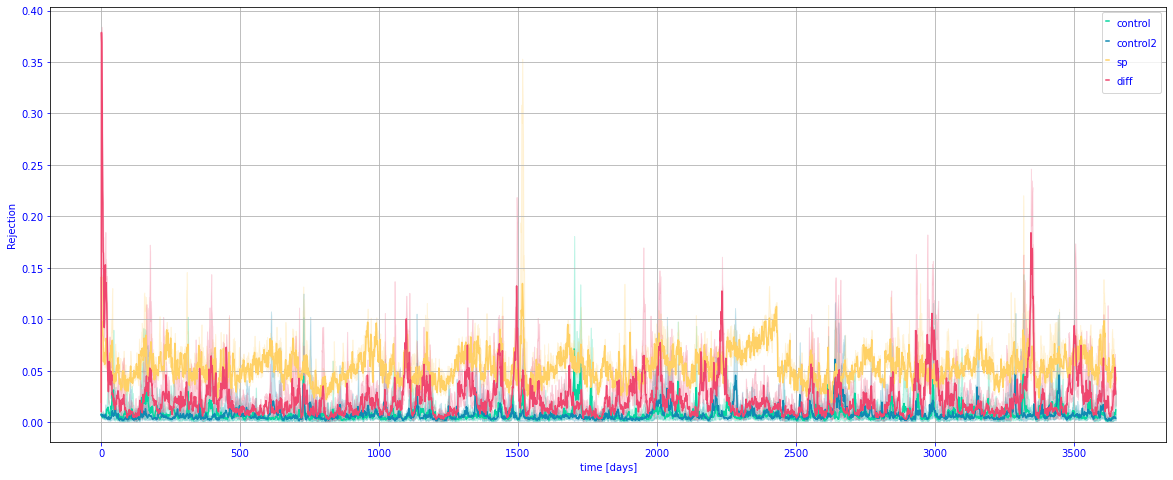

In [78]:
varname = "ashfl_s"
freq = "1D"
here = "__xarray_dataarray_variable__"
results = xr.open_dataset(f"../data/results/{freq}/{varname}.nc")[here]
avgrej = xr.open_dataset(f"../data/rejection/{freq}/{varname}_avg.nc")[here]
# to_plot = np.mean(avgrej[:, 3, :, :, :], axis=0)
time = results["newtime"]
time2 = np.arange(len(time))

fig, ax = plt.subplots(figsize=(20,8))
colors = ["#06d6a0", "#118ab2", "#ffd166", "#ef476f"] # https://coolors.co/palette/ef476f-ffd166-06d6a0-118ab2-073b4c

for o in range(results.shape[1]):
    ax.plot(
        time2,
        np.mean(results[:, o, :], axis=0),
        label=comps[notref[o]],
        color=colors[o],
    )
    ax.fill_between(
        time2,
        *np.quantile(results[:, o, :], [0.05, 0.95], axis=0),
        color=colors[o],
        alpha=0.2,
    )

ax.set_xlabel("time [days]")
ax.set_ylabel("Rejection")
ax.grid(True)
ax.legend()

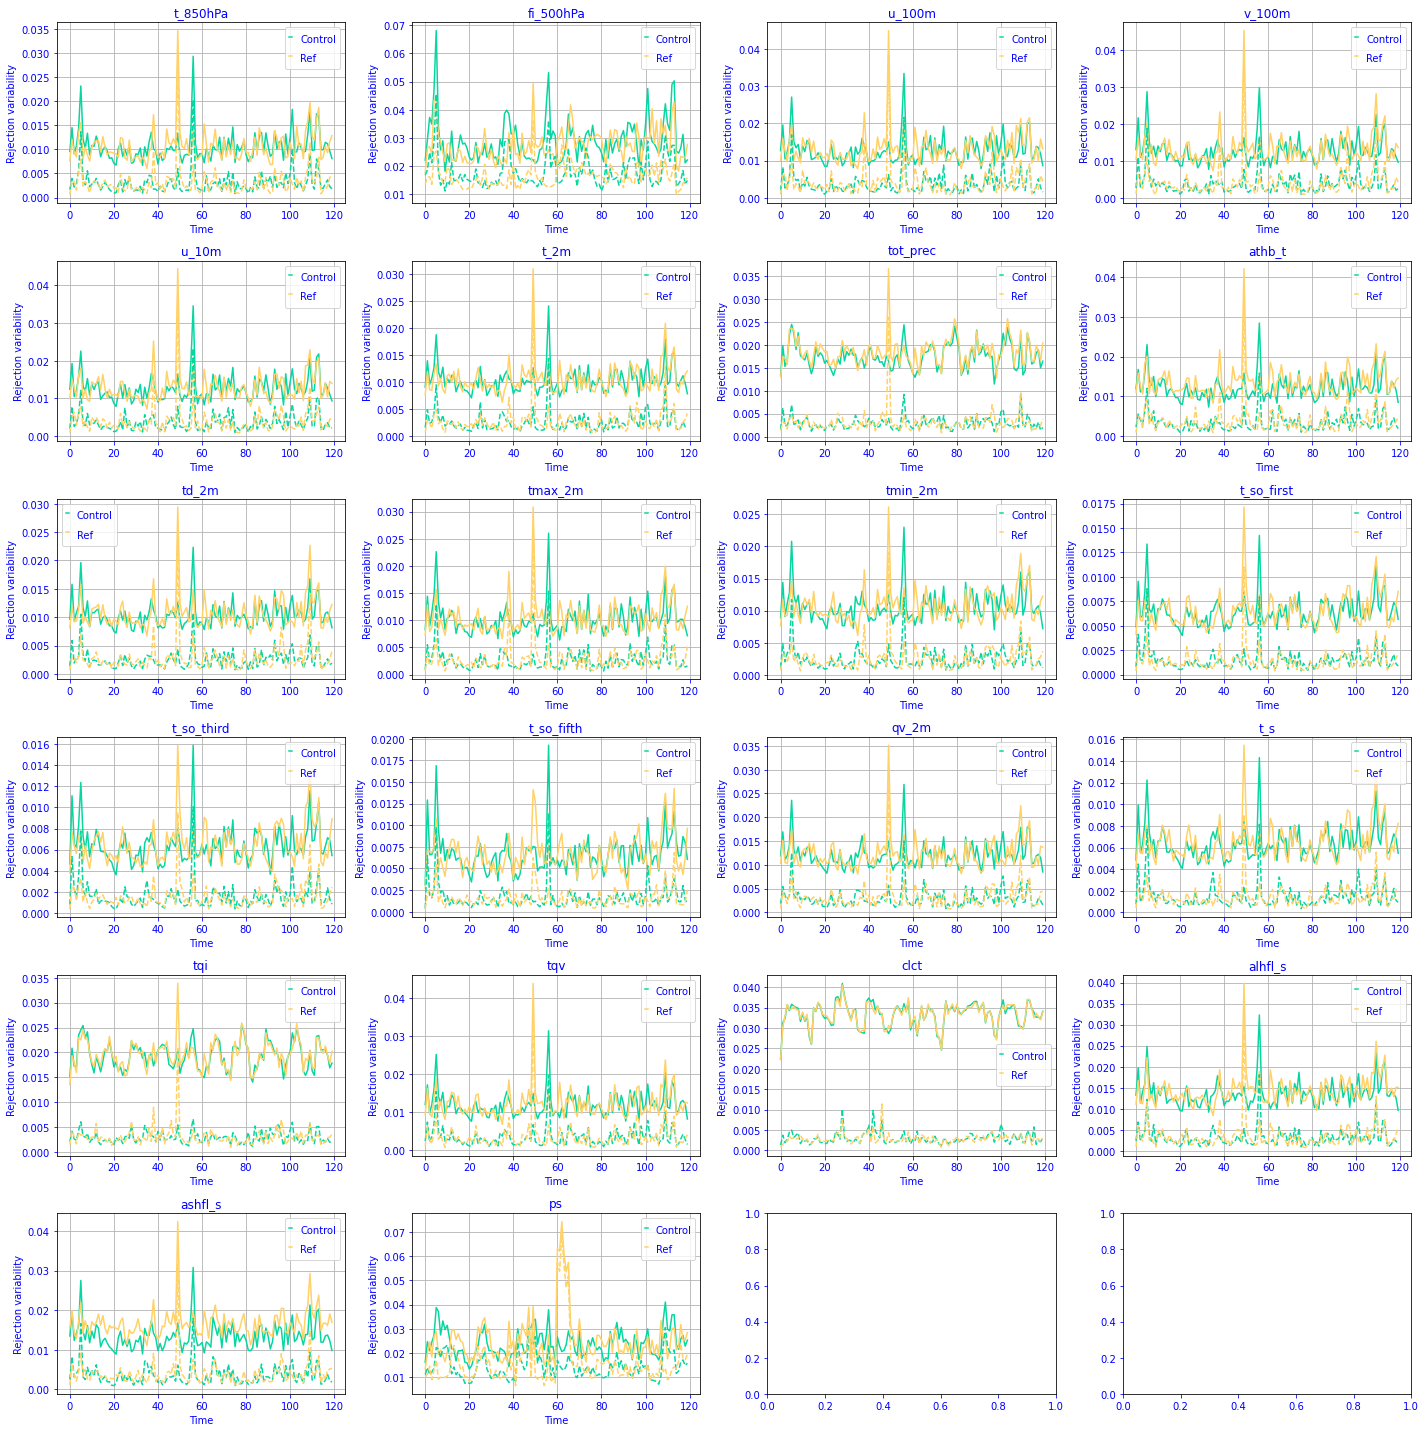

In [75]:
freq = "1D"
fig, axes = plt.subplots(6, 4, tight_layout=True, figsize=(20, 20))
axes = axes.flatten()
i = 0
for varname in variablemap.keys():
    ax = axes[i]
    results = xr.open_dataset(f"../data/results/{freq}/{varname}.nc")[here]
    results = results.resample(newtime="1M").mean().values
    avgrej = xr.open_dataset(f"../data/rejection/{freq}/{varname}_avg.nc")[here].values
    x = np.arange(avgrej.shape[2])
    a = np.mean(np.std(avgrej[:, [0, 2], :, :, :], axis=0), axis=(2, 3))
    b = np.std(results[:, [0, 2], :], axis=0)
    ax.plot(x, a[0], color=colors[0], label="Control")
    ax.plot(x, a[1], color=colors[2], label="Ref")
    ax.plot(x, b[0], color=colors[0], linestyle="--")
    ax.plot(x, b[1], color=colors[2], linestyle="--")
    ax.set_title(varname)
    ax.set_ylabel("Rejection variability")
    ax.set_xlabel("Time")
    ax.grid(True)
    ax.legend()
    i += 1

In [10]:
freq = "1D"
varname = "tot_prec"
results = xr.open_dataset(f"../data/results/{freq}/{varname}.nc")[HERE].values
avgrej = xr.open_dataset(f"../data/rejection/{freq}/{varname}_avg.nc")[HERE].values
bigname = variablemap[varname][1]
fnames = [f"../data/main/{varname}s{j}.nc" for j in range(2)]
darr = xr.open_mfdataset(fnames)[bigname].values

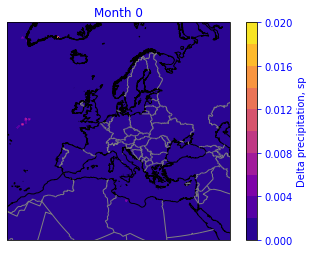

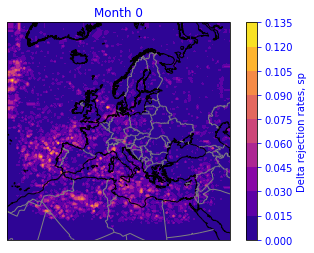

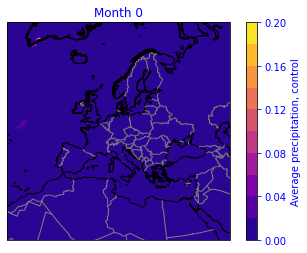

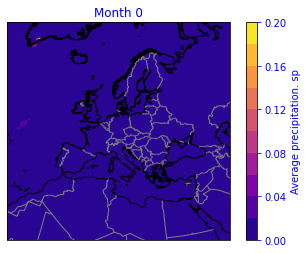

In [21]:
to_plot = [
    np.abs(np.mean(darr[3, :, :, :, :], axis=-1) - np.mean(darr[0, :, :, :, :], axis=-1)),
    np.abs(np.mean(avgrej[:, 2, :, :, :], axis=0) - np.mean(avgrej[:, 0, :, :, :], axis=0)),
    np.mean(darr[0, :, :, :, :], axis=-1),
    np.mean(darr[3, :, :, :, :], axis=-1),
]
levels = [10, 10, 10, 10]
titles = [
    "Delta precipitation, sp",
    "Delta rejection rates, sp",
    "Average precipitation, control",
    "Average precipitation. sp"
]
COLOR = "blue"
mpl.rcParams["text.color"] = COLOR
mpl.rcParams["axes.labelcolor"] = COLOR
mpl.rcParams["xtick.color"] = COLOR
mpl.rcParams["ytick.color"] = COLOR
mpl.rcParams["animation.html"] = "jshtml"
# Projection for map

pole_lat = aDset["rotated_pole"].getncattr("grid_north_pole_latitude")
pole_lon = aDset["rotated_pole"].getncattr("grid_north_pole_longitude")

# Transform for rotated lat/lon
crs_rot = ctp.crs.RotatedPole(pole_longitude=pole_lon, pole_latitude=pole_lat)

# Figure
transform = ctp.crs.PlateCarree()
projection = crs_rot
figs, axes = zip(*[
    plt.subplots(
        1,
        1,
        subplot_kw={"projection": projection}
    )
    for _ in range(len(to_plot))
])
# axes = np.atleast_1d(axes)
cmap = plt.get_cmap("plasma")

# Add coastline and boarders
coastline = ctp.feature.NaturalEarthFeature(
    "physical", "coastline", "10m", edgecolor="black", facecolor="none"
)
borders = ctp.feature.NaturalEarthFeature(
    "cultural", "admin_0_boundary_lines_land", "10m", edgecolor="grey", facecolor="none"
)
plt_rej = []
for j in range(len(to_plot)):
    ax = axes[j]
    fig = figs[j]
    plt_rej.append(
        ax.contourf(
            lon,
            lat,
            to_plot[j][0],
            levels=levels[j],
            transform=transform,
            transform_first=True,
            cmap=cmap,
            zorder=0,
        )
    )

    ax.add_feature(coastline)
    ax.add_feature(borders)
    ax.set_xmargin(0)
    ax.set_ymargin(0)
    ax.set_title("Month 0")

    cbar = fig.colorbar(plt_rej[j], ax=ax)
    cbar.ax.set_ylabel(titles[j])


def animate(i, j):
    ax = axes[j]
    fig = figs[j]
    global plt_rej
    for c in plt_rej[j].collections:
        c.remove()
    plt_rej[j] = ax.contourf(
        lon,
        lat,
        # lon,
        to_plot[j][i],
        levels=levels[j],
        transform=transform,
        transform_first=True,
        cmap=cmap,
        zorder=0,
    )
    cbar = fig.colorbar(plt_rej[j], cax=fig.axes[1])
    cbar.ax.set_ylabel(titles[j])
    ax.set_title(f"Month {i + 1}")
    return plt_rej

In [22]:
j = 0
anim = animation.FuncAnimation(
    figs[j], partial(animate, j=j), frames=10, repeat=False
)
disp.HTML(anim.to_jshtml())

/project/pr133/hbanderi/miniconda3/envs/env/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'transform_first'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


In [14]:
j = 2
anim = animation.FuncAnimation(
    figs[j], partial(animate, j=j), frames=10, repeat=False
)
disp.HTML(anim.to_jshtml())

/project/pr133/hbanderi/miniconda3/envs/env/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'transform_first'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


In [15]:
j = 3
anim = animation.FuncAnimation(
    figs[j], partial(animate, j=j), frames=10, repeat=False
)
disp.HTML(anim.to_jshtml())

/project/pr133/hbanderi/miniconda3/envs/env/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'transform_first'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


In [ ]:
which = 0
n_sam = 7
comp1 = 0
ref = 2

idxs_ref = ran.choice(arrs[which].shape[-1], n_sam, replace=replace)
idxs = ran.choice(arrs[which].shape[-1], n_sam, replace=replace)
n_days, nx, ny = arrs[which].shape[1:4]

arr1 = np.transpose(arrs[which][comp1, :, :, :, idxs], (1, 2, 3, 0))
arr2 = np.transpose(arrs[which][ref, :, :, :, idxs_ref], (1, 2, 3, 0))

christian_ks = ks.ks(arr1, arr2, nbins, 1.358)
christian_mwu = mwu.mwu(arr1, arr2, u_crit)

In [ ]:
from scipy.stats import ks_2samp, mannwhitneyu


def one_t(sarr1, sarr2, nx, ny):
    st = np.empty((nx, ny))
    sta = np.ma.array(st, mask=sarr1.mask[:, :, 0])
    p = sta.copy()
    if np.all(sarr1.mask):
        return sta, p
    for x in range(nx):
        for y in range(ny):
            sta[x, y], p[x, y] = ks_2samp(sarr1[x, y, :], sarr2[x, y, :])
    return sta, p

In [ ]:
ti = timer.time()
sta, p = zip(
    *Parallel(n_jobs=12, verbose=12, pre_dispatch="all")(
        delayed(one_t)(arr1[t, :, :, :], arr2[t, :, :, :], nx, ny)
        for t in range(n_days)
    )
)
print(timer.time() - ti)

scipy_ks = sta > 1.358 * np.sqrt(2 / n_sam)

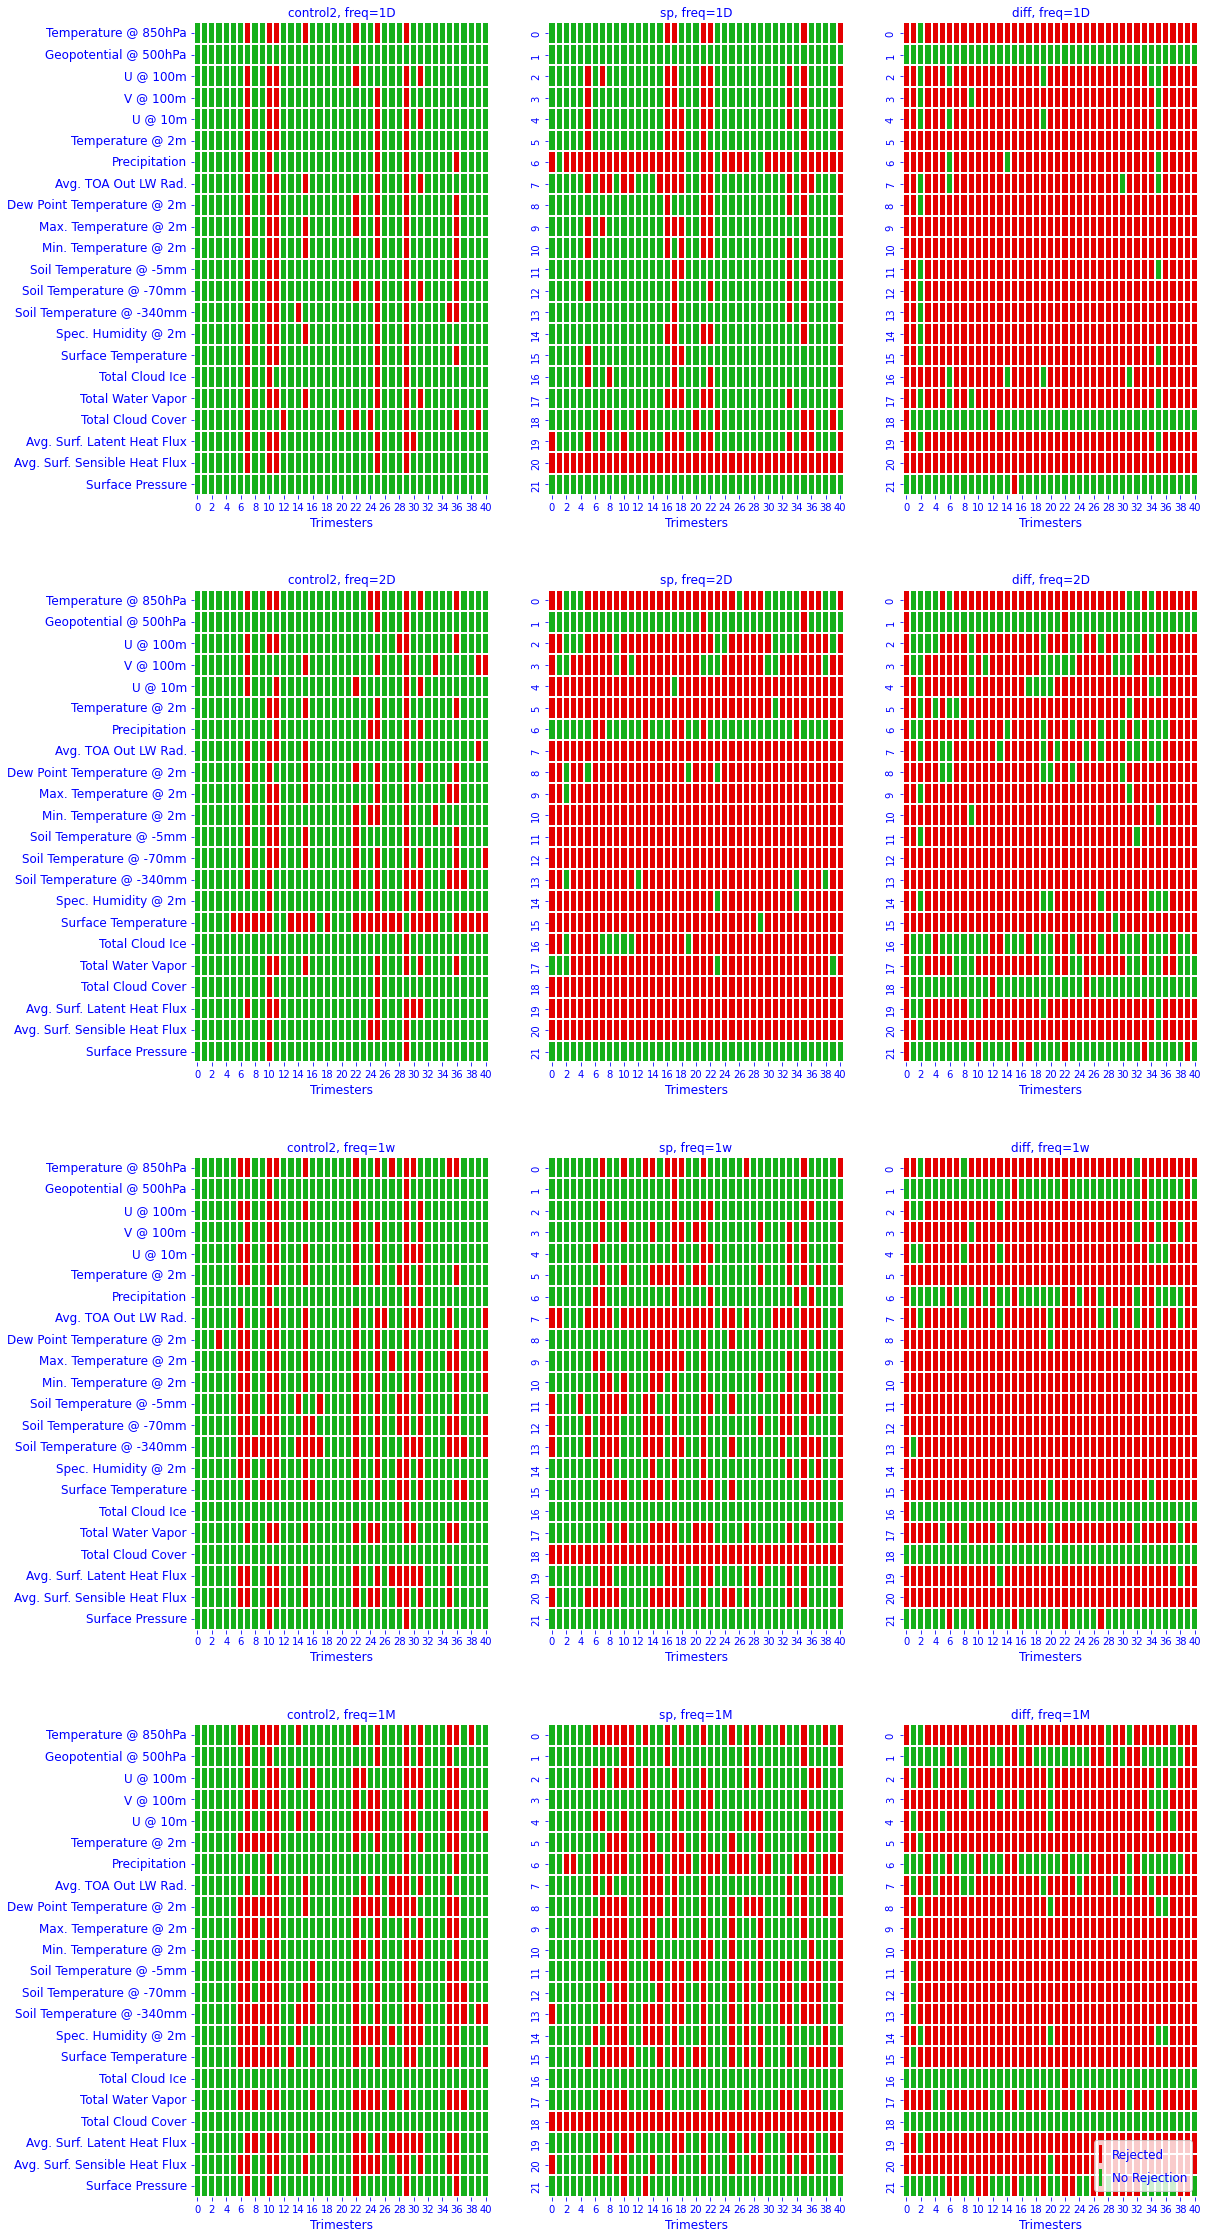

In [47]:
vm = variablemap
nv = len(vm)
freqs = ["1D", "2D", "1w", "1M"]
fsize=12

cmap = mpl.cm.get_cmap("RdYlGn", 2)
newcolors = cmap(np.linspace(0, 1, 2))
newcolors[-1, :] = [21 / 256, 176 / 256, 26 / 256, 1]
newcolors[0, :] = [229 / 256, 0, 0, 1]
cmap = mpl.colors.ListedColormap(newcolors)

comps = metadata["comps"]
notref = np.where(comps != "ref")[0]
ref = np.where(comps == "ref")[0][0]
others = np.where(comps[notref] != "control")[0]
control = np.where(comps == "control")[0][0]

rc_q = [{} for i in range(len(freqs))]
rd = np.empty((len(freqs), nv, len(others)), dtype=object)
rd1 = rd.copy()
rd2 = rd.copy()
vlabels = [vm[key][-1] for key in vm]

fig, axes = plt.subplots(len(freqs), len(others), figsize=(18, 40))
axes = np.atleast_2d(axes)
for j in range(len(freqs)):
    i = 0
    freq = freqs[j]
    for varname in vm:
        results = xr.open_dataset(f"../data/results/{freq}/{varname}.nc")[HERE]
        # .95 quantile from Control
        rc_q[j][varname] = np.quantile(results[:, control, :], 0.95, axis=0)

        # Global result
        for o in range(len(others)):
            rd1[j, i, o] = rc_q[j][varname] >= np.mean(results[:, others[o], :], axis=0)
            rd[j, i, o] = rd1[j, i, o].resample(newtime="3M").mean().astype(float).to_numpy()
            rd2[j, i, o] = rd1[j, i, o].resample(newtime="1M").mean().astype(float).to_numpy()
        i += 1
#     # Plot it
    a = np.empty((nv, len(others), len(rd[j, 0, 0])))
    for o in range(len(others)):
        a[:, o, :] = np.stack(rd[j, :, o])
    for o in range(len(others)):
        ax = axes[j, o]
        sns.heatmap(
            a[:, o, :] > 0.75, linewidth=1.8, cmap=cmap, ax=ax, cbar=False, vmax=1, vmin=0
        )
        ax.set_xlabel("Trimesters", fontsize=fsize)
        ax.set_title(f"{comps[notref[others[o]]]}, freq={freq}", fontsize=fsize)
    #              str(round((result_diff.size-result_diff.sum())/result_diff.size*100,1)),
    axes[j, 0].set_yticklabels(vlabels, rotation=0, fontsize=fsize)

    rect1 = mpl.patches.Rectangle((0, 0), 1, 1, facecolor=newcolors[-1])
    rect2 = mpl.patches.Rectangle((0, 0), 1, 1, facecolor=newcolors[0])
    plt.rcParams["legend.handlelength"] = 0.3
    plt.rcParams["legend.handleheight"] = 1.85
    plt.legend(
        (rect2, rect1), ("Rejected", "No Rejection"), fontsize=fsize, loc="lower right"
    )

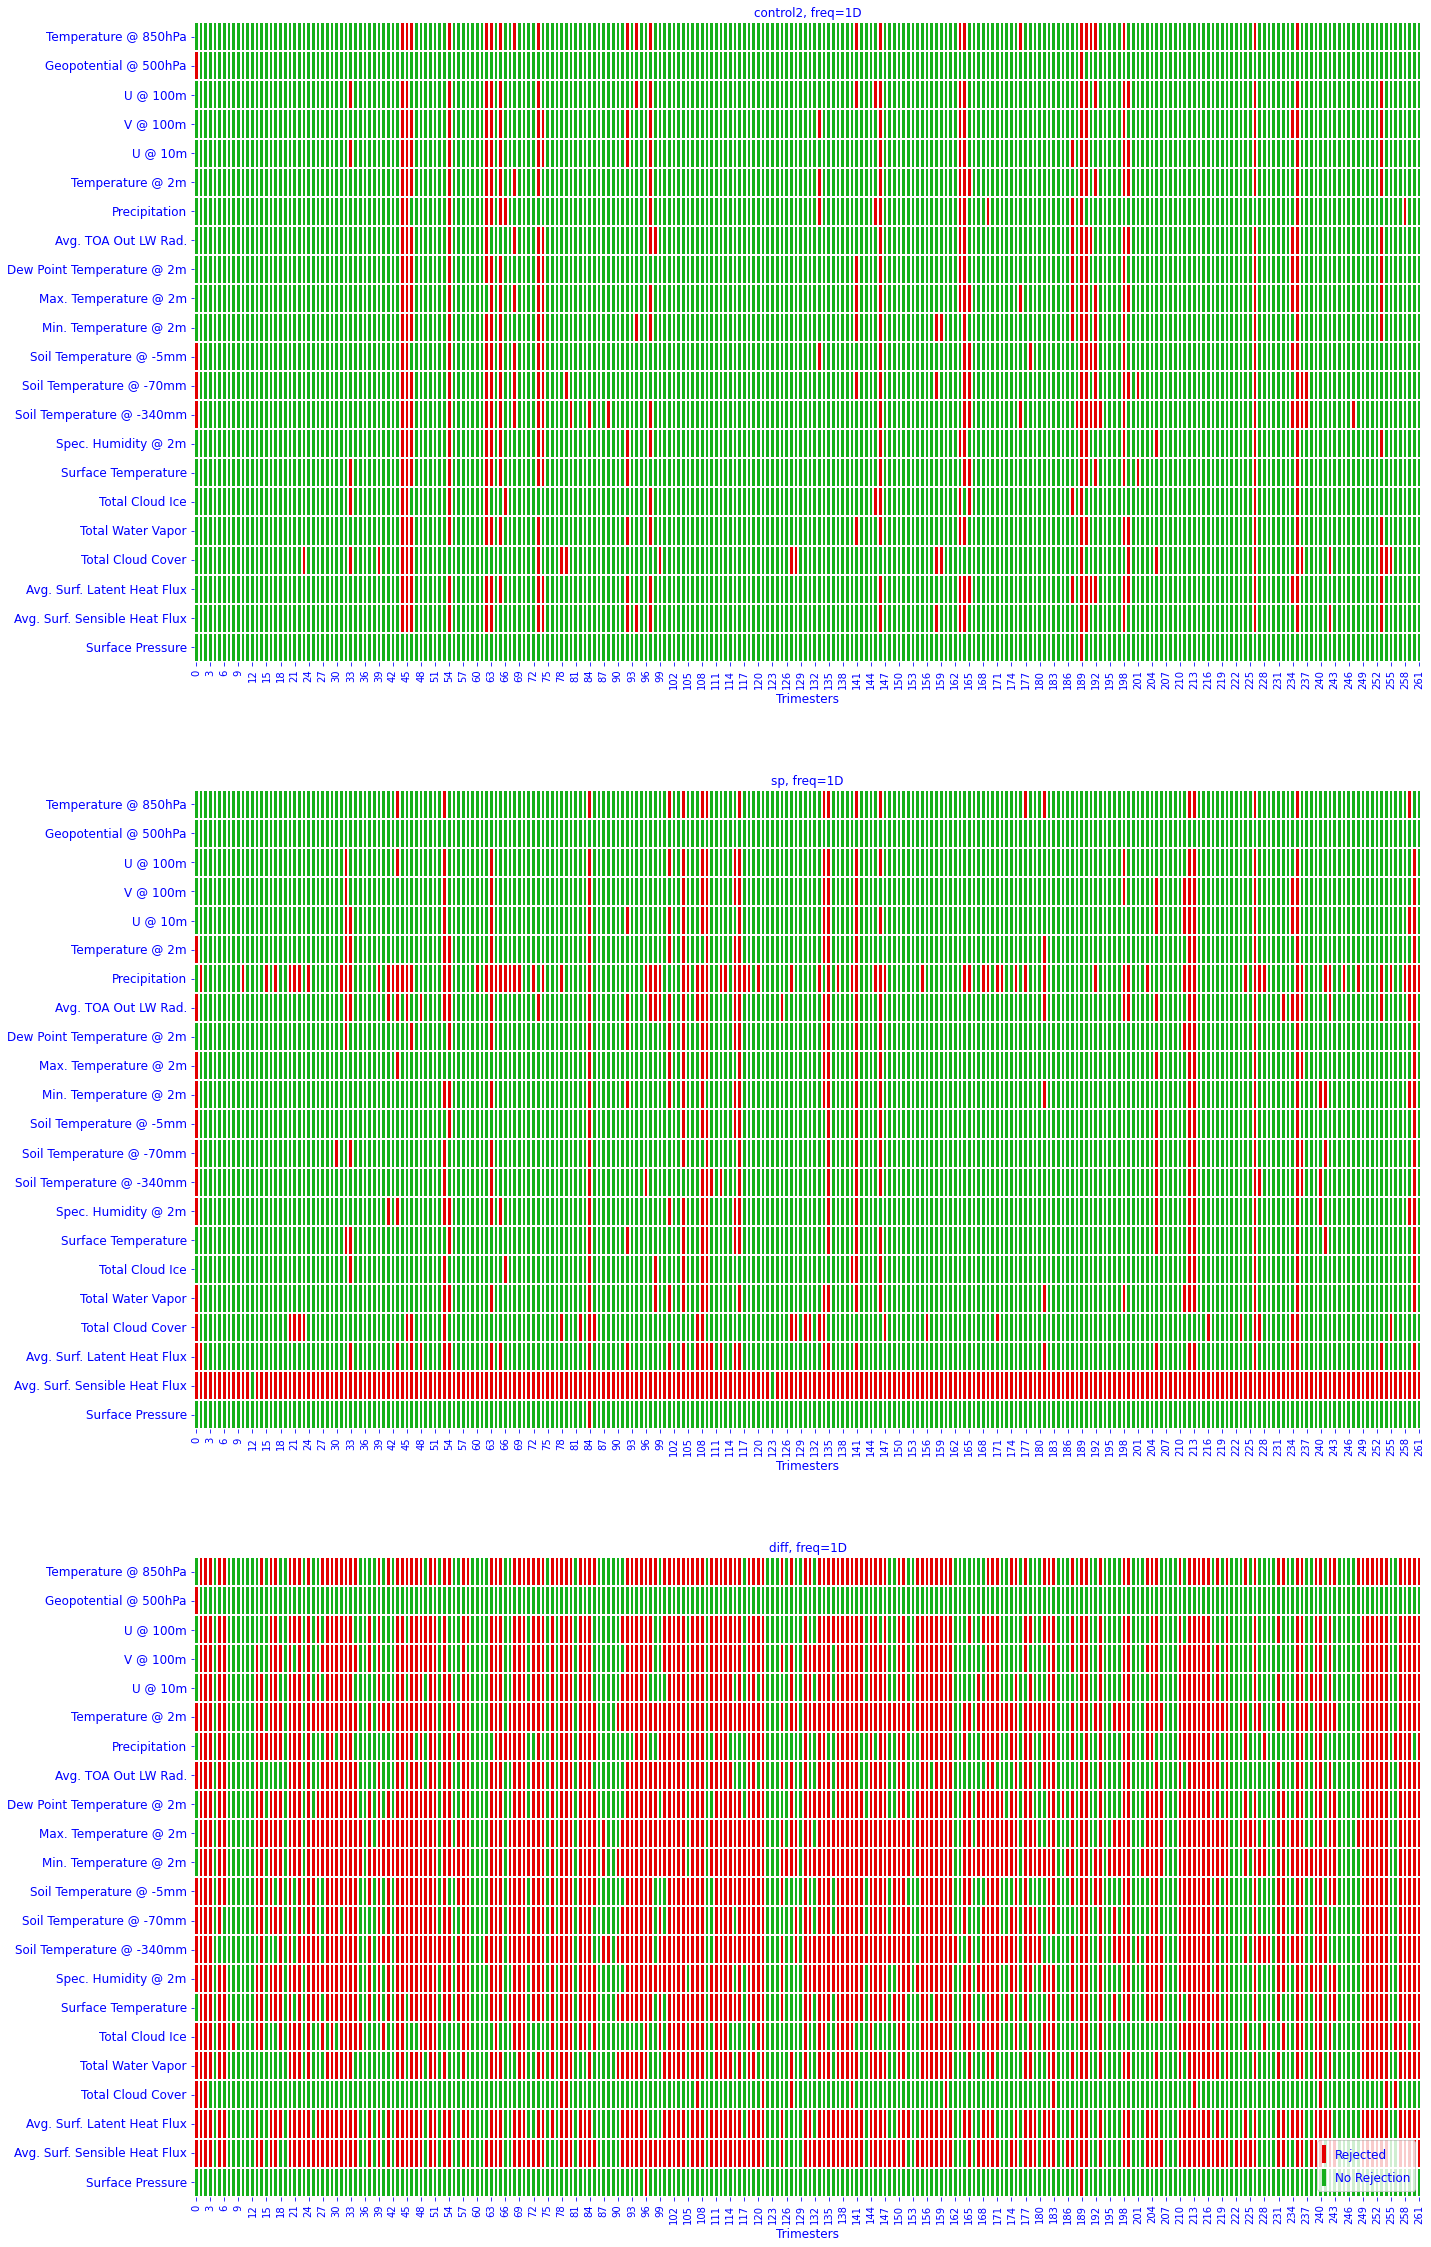

In [66]:
vm = variablemap
nv = len(vm)
freq = "1D"
fsize=12

cmap = mpl.cm.get_cmap("RdYlGn", 2)
newcolors = cmap(np.linspace(0, 1, 2))
newcolors[-1, :] = [21 / 256, 176 / 256, 26 / 256, 1]
newcolors[0, :] = [229 / 256, 0, 0, 1]
cmap = mpl.colors.ListedColormap(newcolors)

comps = metadata["comps"]
notref = np.where(comps != "ref")[0]
ref = np.where(comps == "ref")[0][0]
others = np.where(comps[notref] != "control")[0]
control = np.where(comps == "control")[0][0]

rc_q = [{} for i in range(len(freqs))]
rd = np.empty((nv, len(others)), dtype=object)
vlabels = [vm[key][-1] for key in vm]

fig, axes = plt.subplots(len(others), 1, figsize=(22, 40))
axes = np.atleast_1d(axes)
i = 0
for varname in vm:
    results = xr.open_dataset(f"../data/results/{freq}/{varname}.nc")[HERE]
    # .95 quantile from Control
    rc_q[j][varname] = np.quantile(results[:, control, :], 0.95, axis=0)
    # Global result
    for o in range(len(others)):
        rd[i, o] = (rc_q[j][varname] >= np.mean(results[:, others[o], :], axis=0)).resample(newtime="2w").mean().astype(float).to_numpy()
    i += 1
#     # Plot it
a = np.empty((nv, len(others), len(rd[0, 0])))
for o in range(len(others)):
    a[:, o, :] = np.stack(rd[:, o])
for o in range(len(others)):
    ax = axes[o]
    sns.heatmap(
        a[:, o, :] > 0.5, linewidth=1.8, cmap=cmap, ax=ax, cbar=False, vmax=1, vmin=0
    )
    ax.set_xlabel("Trimesters", fontsize=fsize)
    ax.set_title(f"{comps[notref[others[o]]]}, freq={freq}", fontsize=fsize)
    #              str(round((result_diff.size-result_diff.sum())/result_diff.size*100,1)),
    axes[o].set_yticklabels(vlabels, rotation=0, fontsize=fsize)

rect1 = mpl.patches.Rectangle((0, 0), 1, 1, facecolor=newcolors[-1])
rect2 = mpl.patches.Rectangle((0, 0), 1, 1, facecolor=newcolors[0])
plt.rcParams["legend.handlelength"] = 0.3
plt.rcParams["legend.handleheight"] = 1.85
plt.legend(
    (rect2, rect1), ("Rejected", "No Rejection"), fontsize=fsize, loc="lower right"
)

In [ ]:
vm = variablemap
nv = 1
freqs = ["1D", "2D", "1w", "1M"]

fsize = 12

cmap = mpl.cm.get_cmap("RdYlGn", 2)
newcolors = cmap(np.linspace(0, 1, 2))
newcolors[-1, :] = [21 / 256, 176 / 256, 26 / 256, 1]
newcolors[0, :] = [229 / 256, 0, 0, 1]
cmap = mpl.colors.ListedColormap(newcolors)

comps = metadata["comps"]
notref = np.where(comps != "ref")[0]
ref = np.where(comps == "ref")[0][0]
others = np.where(comps[notref] != "control")[0]
control = np.where(comps == "control")[0][0]

rc_q = [{} for i in range(len(freqs))]
rd = np.empty((len(freqs), nv, len(others)), dtype=object)
rd0 = rd.copy()
vlabels = [vm[key][-1] for key in vm]

fig, axes = plt.subplots(len(freqs), len(others), figsize=(18, 40))
axes = np.atleast_2d(axes)
for j in range(len(freqs)):
    i = 0
    freq = freqs[j]
    for varname in list(vm.keys())[:nv]:
        avgrejection = xr.open_dataset(f"../data/rejection/{freq}/{varname}_avg.nc")[HERE]
        # .95 quantile from Control
        rc_q[j][varname] = np.quantile(avgrejection[:, control, :, :, :], 0.95, axis=0)

        # Global result
        for o in range(len(others)):
            print(o)
            rd0[j, i, o] = np.mean(rc_q[j][varname] >= np.mean(avgrejection[:, others[o], :, :, :], axis=0), axis=(-2, -1))
            rd[j, i, o] = rd0[j, i, o].resample(newtime="3M").mean().astype(float).to_numpy()
        i += 1
#     # Plot it
    a = np.empty((nv, len(others), len(rd[j, 0, 0])))
    for o in range(len(others)):
        a[:, o, :] = np.stack(rd[j, :, o])
    for o in range(len(others)):
        ax = axes[j, o]
        sns.heatmap(
            a[:, o, :] > 0.95, linewidth=1.8, cmap=cmap, ax=ax, cbar=False, vmax=1, vmin=0
        )
        ax.set_xlabel("Trimesters", fontsize=fsize)
        ax.set_title(f"{comps[notref[others[o]]]}, freq={freq}", fontsize=fsize)
    #              str(round((result_diff.size-result_diff.sum())/result_diff.size*100,1)),
    axes[j, 0].set_yticklabels(vlabels[:nv], rotation=0, fontsize=fsize)

    rect1 = mpl.patches.Rectangle((0, 0), 1, 1, facecolor=newcolors[-1])
    rect2 = mpl.patches.Rectangle((0, 0), 1, 1, facecolor=newcolors[0])
    plt.rcParams["legend.handlelength"] = 0.3
    plt.rcParams["legend.handleheight"] = 1.85
    plt.legend(
        (rect2, rect1), ("Rejected", "No Rejection"), fontsize=fsize, loc="lower right"
    )

In [6]:
freq = "1D"
varname = "athb_t"
results = xr.open_dataset(f"../data/results/{freq}/{varname}.nc")[HERE]
avgrej = xr.open_dataset(f"../data/rejection/{freq}/{varname}_avg.nc")[HERE]
results0 = xr.open_dataset(f"../data/results/{freq}/{varname}0.nc")[HERE]
avgrej0 = xr.open_dataset(f"../data/rejection/{freq}/{varname}_avg0.nc")[HERE]

In [7]:
comps = metadata["comps"]
notref = np.where(comps != "ref")[0]
ref = np.where(comps == "ref")[0][0]
others = np.where(comps[notref] != "control")[0]
control = np.where(comps == "control")[0][0]

## Space average first, high tolerance
rc_q = np.quantile(results[:, control, :], 0.95, axis=0)
rda0 = []
rda1 = []
for o in range(len(others)):
    rda0.append(rc_q >= np.mean(results[:, others[o], :], axis=0))
    rda1.append(rda0[o].resample(newtime="1M").mean().astype(float).to_numpy())
    
rda1 = np.stack(rda1)

## Space average first, low tolerance
rc_q = np.quantile(results0[:, control, :], 0.95, axis=0)
rdb0 = []
rdb1 = []
for o in range(len(others)):
    rdb0.append(rc_q >= np.mean(results0[:, others[o], :], axis=0))
    rdb1.append(rdb0[o].resample(newtime="1M").mean().astype(float).to_numpy())
    
rdb1 = np.stack(rdb1)

## Test first, high tolerance
rc_q = np.quantile(avgrej[:, control, :, :, :], 0.95, axis=0)
rdc0 = []
rdc1 = []
for o in range(len(others)):
    rdc0.append(np.mean(rc_q >= np.mean(avgrej[:, others[o], :, :, :], axis=0), axis=(-2, -1)))
    rdc1.append(rdc0[o].resample(newtime="1M").mean().astype(float).to_numpy())
    
rdc1 = np.stack(rdc1)

## Test first, low tolerance
rc_q = np.quantile(avgrej0[:, control, :, :, :], 0.95, axis=0)
rdd0 = []
rdd1 = []
for o in range(len(others)):
    rdd0.append(np.mean(rc_q >= np.mean(avgrej0[:, others[o], :, :, :], axis=0), axis=(-2, -1)))
    rdd1.append(rdd0[o].resample(newtime="1M").mean().astype(float).to_numpy())
    
rdd1 = np.stack(rdd1)

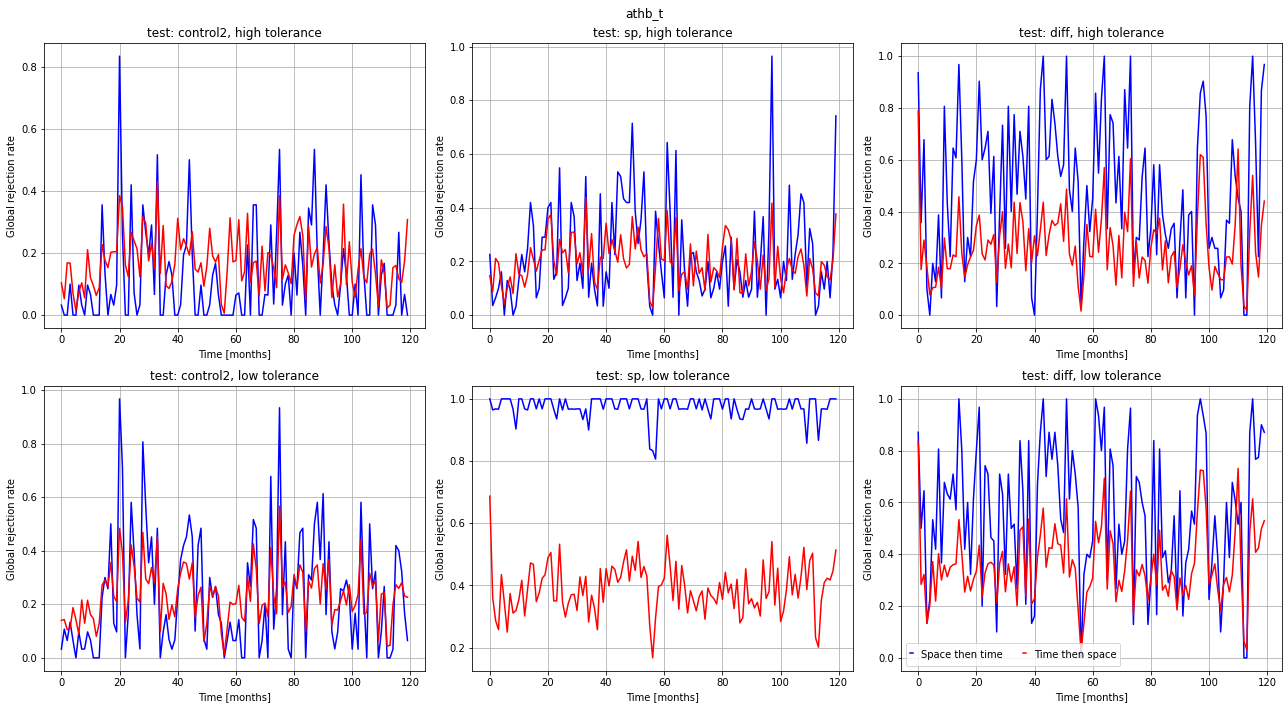

In [8]:
fig, axes = plt.subplots(2, 3, tight_layout=True, figsize=(18, 10))
time = np.arange(rdb1.shape[1])
fig.suptitle(varname)
for o in range(len(others)):
    ax = axes[:, o]
    ax[0].plot(time, 1 - rda1[o, :], 'b', label="Space then time")
    ax[0].plot(time, 1 - rdc1[o, :], 'r', label="Time then space")
    ax[0].set_xlabel("Time [months]")
    ax[0].set_ylabel("Global rejection rate")
    ax[0].grid(True)
    ax[0].set_title(f"test: {comps[notref[others[o]]]}, high tolerance")
    ax[1].plot(time, 1 - rdb1[o, :], 'b', label="Space then time")
    ax[1].plot(time, 1 - rdd1[o, :], 'r', label="Time then space")
    ax[1].set_xlabel("Time [months]")
    ax[1].set_ylabel("Global rejection rate")
    ax[1].grid(True)
    ax[1].set_title(f"test: {comps[notref[others[o]]]}, low tolerance")
axes[-1, -1].legend(ncol=2)

<xarray.DataArray '__xarray_dataarray_variable__' ()>
array(0.12486309)
<xarray.DataArray '__xarray_dataarray_variable__' ()>
array(0.21522453)
<xarray.DataArray '__xarray_dataarray_variable__' ()>
array(0.48028478)


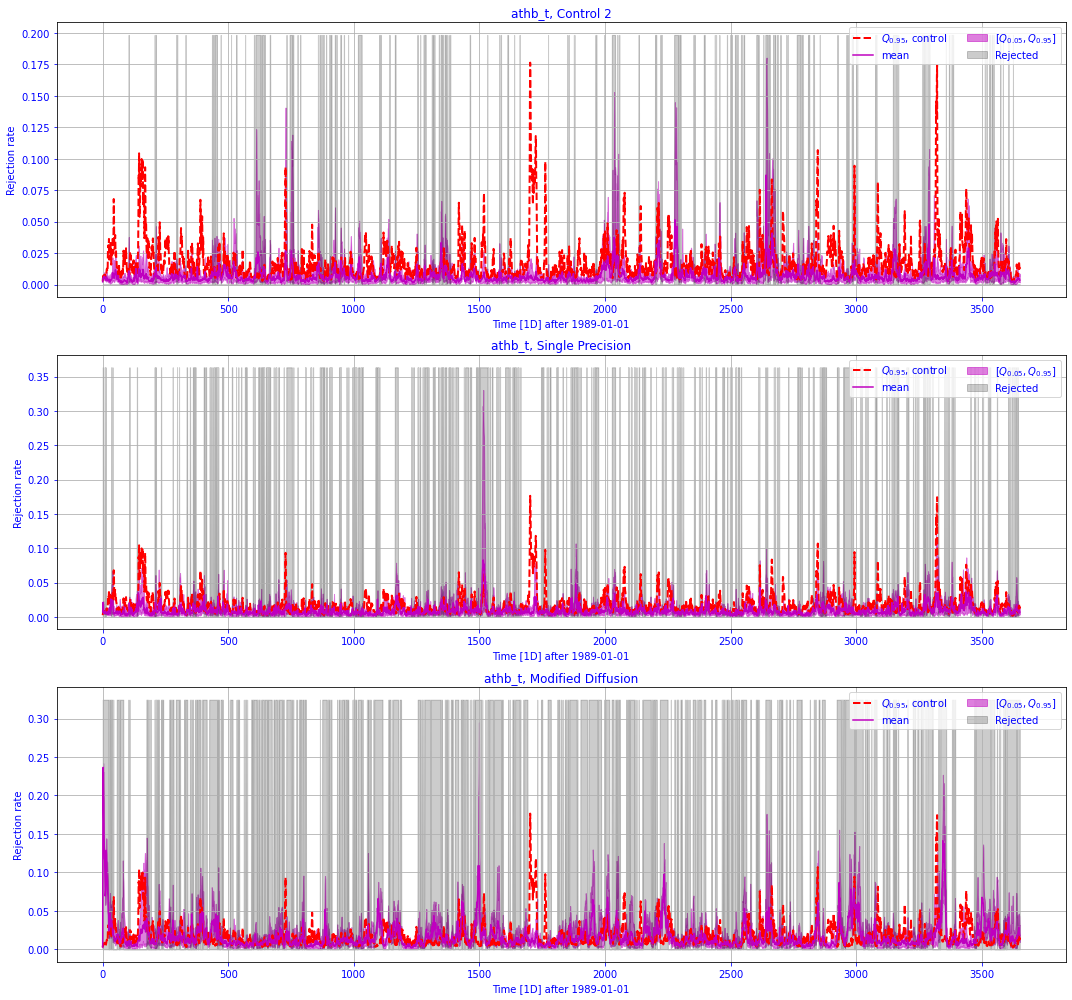

In [119]:
varname = "athb_t"
freq = "1D"
results = xr.open_dataset(f"../data/results/{freq}/{varname}.nc")[HERE]
time = np.arange(len(results["newtime"]))
timeslice = slice(0, len(time))
comparisons = [
    [0, "control", "Control"],
    [1, "control2", "Control 2"],
    [2, "sp", "Single Precision"],
    [3, "diff", "Modified Diffusion"],
]
cs = [[comparisons[0], comparisons[i]] for i in range(1, 4)]
rejected = []
fig, axes = plt.subplots(len(cs), 1, tight_layout=True, figsize=(15, 14))
for i in range(len(cs)):
    c = cs[i]
    ax = axes[i]
    ax.plot(
        time[timeslice],
        np.quantile(results[:, c[0][0], timeslice], 0.95, axis=0),
        "r--",
        lw=2,
        label="$Q_{0.95}$, control",
    )

    ax.plot(
        time[timeslice],
        np.mean(results[:, c[1][0], timeslice], axis=0),
        "m",
        label="mean",
    )
    # ax.fill_between(time,
    #                 *np.quantile(results[:, 0, :], [0.05, 0.95], axis=0),
    #                 alpha=0.3,
    #                 color='r',
    #                 label='$[Q_{0.05}, Q_{0.95}]$, control')
    ax.fill_between(
        time[timeslice],
        *np.quantile(results[:, c[1][0], timeslice], [0.05, 0.95], axis=0),
        alpha=0.5,
        color="m",
        label="$[Q_{0.05}, Q_{0.95}]$",
    )
    rejected.append(
        np.quantile(results[:, c[0][0], timeslice], 0.95, axis=0)
        < np.mean(results[:, c[1][0], timeslice], axis=0)
    )
    ax.fill_between(
        time[timeslice],
        0,
        1.1
        * max(
            np.amax(np.quantile(results[:, c[0][0], timeslice], 0.95, axis=0)),
            np.amax(np.quantile(results[:, c[1][0], timeslice], 0.95, axis=0)),
        )
        * rejected[i],
        alpha=0.2,
        color="k",
        label="Rejected",
    )
    # ax.fill_between(time,
    #                 *np.quantile(results[:, 1, :], [0.0, 1.0], axis=0),
    #                 alpha=0.3,
    #                 color='m',
    #                 label='$[Q_{0.0}, Q_{1.0}]$')

    ax.grid(True)
    ax.set_xlabel(f"Time [{freq}] after {nicertsta}")
    ax.set_ylabel("Rejection rate")
    ax.set_title(f"{varname}, {c[1][2]}")
    ax.legend(ncol=2)

    print(np.sum(rejected[i]) / len(time[timeslice]))

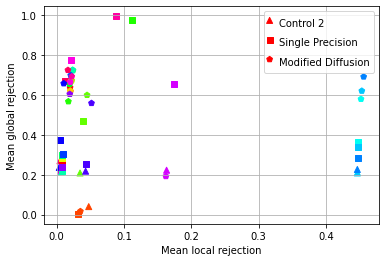

In [41]:
freq = "1D"
fig, ax = plt.subplots()
nv = len(variablemap)
offset = 1
cmap = mpl.cm.get_cmap("hsv", nv + offset)
colors = cmap(np.linspace(0, 1, nv + offset))[:-offset]
markers = ["^", "s", "p"]
data = np.empty((2, nv, len(cs)))
i = 0

for varname in variablemap:
    results = xr.open_dataset(f"../data/results/{freq}/{varname}.nc")[HERE]
    for j in range(len(cs)):
        c = cs[j]
        data[0, i, j] = np.mean(results[:, c[1][0], :])
        data[1, i, j] = np.mean(
            np.quantile(results[:, c[0][0], :], 0.95, axis=0)
            < np.mean(results[:, c[1][0], :], axis=0)
        )
    i += 1
    
for j in range(len(cs)):
    ax.scatter(data[0, :, j], data[1, :, j], c=colors, marker=markers[j], label=cs[j][1][2])
    
ax.set_xlabel("Mean local rejection")
ax.set_ylabel("Mean global rejection")
ax.grid(True)
ax.legend()

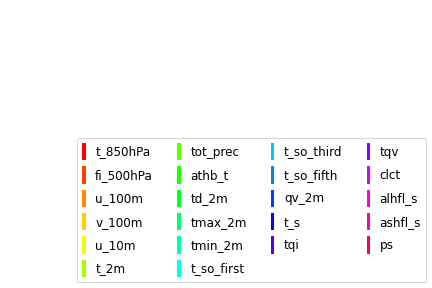

<Figure size 432x288 with 0 Axes>

In [65]:
import pylab
handles = [mpl.patches.Rectangle((0, 0), 1, 1, facecolor=colors[i]) for i in range(nv)]
figLegend = pylab.figure()
pylab.figlegend(
    handles, variablemap.keys(), fontsize=fsize, loc="lower right", ncol=4
)
figLegend.savefig("legend.png")
disp.Image("legend.png")

In [66]:
data

array([[[0.00681773, 0.00774269, 0.02011817],
        [0.04778197, 0.03234786, 0.03540739],
        [0.00748337, 0.00789255, 0.02074602],
        [0.00739721, 0.00744281, 0.02035931],
        [0.00688786, 0.00793779, 0.02193896],
        [0.00754861, 0.0077109 , 0.02268589],
        [0.03486019, 0.03989674, 0.04530765],
        [0.00764836, 0.11219812, 0.01758663],
        [0.00740279, 0.00772506, 0.01955154],
        [0.00738521, 0.00815369, 0.02447599],
        [0.00718313, 0.00806364, 0.02385916],
        [0.44655154, 0.44810521, 0.45197059],
        [0.44657022, 0.4476248 , 0.45317644],
        [0.44656414, 0.44702946, 0.45591279],
        [0.00755982, 0.00890741, 0.02108813],
        [0.0040919 , 0.00557011, 0.01068451],
        [0.04317123, 0.04392837, 0.05188549],
        [0.00722159, 0.00765619, 0.01965923],
        [0.16337402, 0.17433222, 0.16234815],
        [0.00744697, 0.02095833, 0.02032334],
        [0.00758831, 0.08830118, 0.02261095],
        [0.00514074, 0.0129692 , 0

In [67]:
variablemap

{'t_850hPa': ['24h', 'T', 2, 'Temperature @ 850hPa'],
 'fi_500hPa': ['12h', 'FI', 1, 'Geopotential @ 500hPa'],
 'u_100m': ['24h_100zlev', 'U', 0, 'U @ 100m'],
 'v_100m': ['24h_100zlev', 'V', 0, 'V @ 100m'],
 'u_10m': ['24h_2D', 'U_10M', 'U @ 10m'],
 't_2m': ['24h_2D', 'T_2M', 'Temperature @ 2m'],
 'tot_prec': ['24h_2D', 'TOT_PREC', 'Precipitation'],
 'athb_t': ['24h_2D', 'ATHB_T', 'Avg. TOA Out LW Rad.'],
 'td_2m': ['24h_2D', 'TD_2M', 'Dew Point Temperature @ 2m'],
 'tmax_2m': ['24h_2D', 'TMAX_2M', 'Max. Temperature @ 2m'],
 'tmin_2m': ['24h_2D', 'TMIN_2M', 'Min. Temperature @ 2m'],
 't_so_first': ['24h_2D', 'T_SO', 0, 'Soil Temperature @ -5mm'],
 't_so_third': ['24h_2D', 'T_SO', 2, 'Soil Temperature @ -70mm'],
 't_so_fifth': ['24h_2D', 'T_SO', 4, 'Soil Temperature @ -340mm'],
 'qv_2m': ['24h_2D', 'QV_2M', 'Spec. Humidity @ 2m'],
 't_s': ['24h_2D', 'T_S', 'Surface Temperature'],
 'tqi': ['24h_2D', 'TQI', 'Total Cloud Ice'],
 'tqv': ['24h_2D', 'TQV', 'Total Water Vapor'],
 'clct': ['24h